In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.distributed import Client, SSHCluster
from dask import delayed, compute
import time
import os
import glob
import gc
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score
from matplotlib.colors import ListedColormap

np.random.seed(1234)

# Merging Binary Black Holes from Wolf-Rayet - Black Hole progenitors

*Puggioni Dario, Salvador Alberto, Saran Gattorno Giancarlo, Volpi Gaia*

X-ray binaries containing a black hole and a massive star are among the most promising observational candidates for binary black holes (BBHs) progenitors. Mass transfer events play a crucial role in shrinking the orbit of these systems, facilitating their eventual merger. In particular, we focus on Wolf-Rayet stars as they form as a result of significant mass transfer and strong stellar winds that strip away the hydrogen envelope of a massive star. Under the right conditions, a binary system can evolve into a black hole – Wolf-Rayet star system. Such systems may become visible as X-ray binaries because the intense stellar winds can lead to the formation of an accretion disk around the black hole, producing powerful X-ray emissions.

In this project, we utilize the outputs of the population synthesis code SEVN (Stellar EVolution for N-body). The primary objective is to identify the key parameters that determine whether a black hole - Wolf-Rayet star system will evolve into a BBH system that eventually merges via emission of gravitational waves within a Hubble time. 

## 1. Data Preprocessing and Filtering 

In the initial section, our aim is to clean the datasets by removing all the informations that will be unnecessary for further analysis. To achieve this, the main steps we will undertake are:

- Load the dataset containing the evolutionary and initial conditions of the systems.
- Remove all the labels that are irrelevant for our analysis.
- Select the systems that, at a certain point in their evolution, become Wolf-Rayet - black hole binaries.
- Identify which of these systems undergo mass transfer proccesses.
- Determine which of these systems evolve into BBHs.
- Assess which of these BBHs systems end up merging via gravitational waves emission.


We choose to employ the Python open-source library Dask for this task. Given that the dataset we are working with is too large to fit in memory, Dask is an optimal solution as it is designed for parallel computing, enabling Python code to scale across multiple multi-core machines.\
The parallelization of the computing process is performed on a cluster of virtual machines provided by the cloud service CloudVeneto.


### 1.1 The cluster

We set up a cluster on CloudVeneto composed of four VMs: `binary01` at IP `10.67.22.174`, `binary02` at IP `10.67.22.251`, `binary03` at IP `10.67.22.93` and `binaryNFServer` at IP `10.67.22.36`. The dataset is stored in a CloudVeneto volume mounted on `binaryNFServer` and shared between the VMs via NFS. The three VMs that are NFS clients are used for building the dask cluster in charge of the processing task.
`binary01` is the scheduler. `binary01`, `binary02`, `binary03` all act as workers.


We primarily work with Dask DataFrame, a high-level collection that enables parallelization of DataFrame-based workloads. A Dask DataFrame consists of many smaller Pandas DataFrames, partitioned along the index.

In [ ]:
def init_client(nthreads=4, nworkers=1):
    """Initialize the dask client.

    Args:
        nthreads (int): Number of utilized threads per host, maximum and default 4
        nworkers (int): Number of dask workers per host
    """ 
    #shutdown all existing Client instances
    for obj in gc.get_objects():
        if isinstance(obj, Client):
            obj.shutdown()
        
    #Instantiate cluster with specified configs
    cluster = SSHCluster(
        ["binary01", "binary01", "binary02", "binary03"],
        connect_options={"known_hosts":None, 'password': 'password'}, #insert the user's password
        worker_options={"nthreads": nthreads, "n_workers": nworkers},
        scheduler_options={"port": 9876, "dashboard_address": ":7977"}
    )
    
    return Client(cluster)

### 1.2 The dataset

The dataset consists of two outputs computed at different metallicities (Z=0.0014 and Z=0.02) by the population synthesis code SEVN. We work with binary systems whose evolution is described by SEVN including the following processes: wind mass transfer, Roche-lobe overflow (RLO), common envelope (CE), stellar tides, circularization at the RLO onset, collision at periastron, orbit decay by GW emission, and stellar mergers.

SEVN uses a prediction-correction method to adapt the time-step accounting for the large physical range of timescales typical of stellar and binary evolution. To decide the time-step, it looks at a sub-set of stellar and binary properties: if any of them changes too much during a time-step, it reduces the time-step and repeats the calculation. A special treatment is used when a star approaches a change of phase to guarantee that the stellar properties are evaluated just after and before the change of phase. 



The datasets are contained in one folder each, named after their metallicity. Inside each folder we find: 
- For Z=0.02: a single file named `output_0.csv`
- For Z=0.00014: 40 files named `output_*.csv` where * is a placeholder for numbers between 0 and 39

In addition, we have information about the initial conditions of each system considered. This information is contained in the folder `initial`, which includes files of the type `evolved_*.dat`. Output files and evolved files have a one-to-one correspondence. For example, the initial conditions of the systems in `output_0.csv` are present in `evolved_0.dat`. The link between the two is through the 'ID' label, which uniquely identifies a system.

We built a function able to retrieve the path of the folders related to a specific metallicity, the one containing the `output_*.csv` files and the one containing the corresponing `evolved_*.dat` files. This ensures our code is flexible and capable to adapt to potential new data.

In [ ]:
def grab_paths(main_folder, subfolder_index):
    """Grab the directories of ouputs and initial configurations at a given index in the list of available metallicities.
    
    Args:
        main_folder (str): Path to the dataset
        subfolder_index (int): Index in the list of available metallicities
    """
    subfolders = glob.glob(main_folder) #Folders named with numbers, so FS always orders them before initial
    out_folder = subfolders[subfolder_index]
    init_folder = glob.glob(subfolders[-1] + '/*')[subfolder_index]
    
    return out_folder, init_folder

We report below the structure of an `output_*.csv` file:
<span style="color:blue">
runnare
</span> 

In [ ]:
path = './demo_Z0.00014/output_0.csv' # local path of the dataset at Z = 0.02
df = dd.read_csv(path, dtype={'BEvent': float})
df.head(5)

### 1.3 Systems selection

#### 1.3.1 Wolf-Rayet - black hole progenitors 

First, we select the IDs of the systems that, at a certain time step during their evolution, consist of a Wolf-Rayet star (PhaseBSE={7, 8}) and a black hole (PhaseBSE=14). Additionally, we select and save in `df_WRBH` the features we'll use in our analysis: _ID_, _Mass_0_, _Mass_1_, _Semimajor_, and _Eccentricity_. These features correspond to the parameters at the formation of the WR-BH binary.

#### 1.3.2 Mass transfer events

Population-synthesis studies suggest that at least one mass transfer episode is necessary to shrink the orbit of the progenitor binary star and allow the coalescence of the two final black holes within a Hubble time. Keeping this in mind, we decide to consider only systems that undergo mass transfer events. We count these events for each of the previously selected systems, categorizing them into stable and unstable (_MTEvents_stable_ and _MTEvents_unstable_).

**Roche Lobe overflow**

The effective potential in a binary system, which includes the gravitational potential of both stars and the centrifugal force acting on a mass-less test particle, is known as the Roche-Lobe potential. This potential has five Lagrangian points where its gradient is zero. The innermost of these points is called L1, and the equipotential surface passing through L1 connects the gravitational spheres of influence of the two stars. When one star fills its Roche lobe, matter can flow through the L1 point into the Roche lobe of the other star. This process, known as Roche-lobe overflow (RLO), is the primary mechanism for mass transfer between stars in a binary system.

In the case of stable, (quasi-)conservative mass transfer, most, but not necessarily all, of the transferred mass is accreted by the companion star. This process continues until most of the hydrogen-rich envelope of the donor star has either been transferred to the companion or lost from the system. To count the number of stable mass transfer events, we consider the IDs corresponding to the end of an RLO event (BEvent=5).

**Common Envelope**

Mass transfer becomes unstable when the accreting star cannot absorb all the material transferred from the donor star. In this scenario, the excess material accumulates on the accretor, causing it to expand and eventually fill and overfill its Roche lobe. This leads to the formation of a common-envelope (CE) system, where the core of the donor star and the companion star are immersed in the donor's envelope. Once a CE system forms, friction between the binary components and the surrounding envelope causes the stars to spiral closer together. This process continues until enough orbital energy has been released to eject the envelope. This mechanism is believed to be the primary way an initially wide binary can evolve into a very close binary. To count the number of unstable mass transfer events, we consider the IDs corresponding to the start of a CE (BEvent=7) or the start of an unstable RLO ending in a CE (BEvent=11). 

It is crucial to say that we exclude any mass transfer event that directly results in the merging of the two stars, as these would not become gravitational wave merging BBHs. 

#### 1.3.3 Binary black holes

Next, we select the IDs of BBHs (PhaseBSE=14) that merge via gravitational waves emission. To do so we reqiure that the sum of _GWtime_ (GW orbital decay time in Myr) and _BWorldtime_ (time elapsed in the simulations) is smaller than 14 billions years, the Hubble time.

In SEVN _GWtime_ is defined as:
\begin{equation}
\frac{t_{GW}}{1+f_{corr}(e)}
\end{equation}

where $t_{GW}=\frac{5}{26} \frac{c^5}{G^3} \frac{a^4}{M_1 M_2 (M_1+M_2)} (1-e^2)^{\frac{7}{5}}$ accounts for obrital decay and circularization by GWs, and $f_{corr}(e)$ is a correction term at large eccentricities.

#### 1.3.4 Initial conditions

Finally, we add to the filtered systems some of their initial conditions: the masses of the two stars, eccentricity, and semi-major axis.

In [ ]:
def output_analysis(subfolders, record_index, n_partitions=None):
    """Process a single couple of output_*.csv and evolved_*.csv files at a given metallicity.
    
    Args:
        n_partitions (int): Number of partitions per output file
        subfolders (list):  Paths to the respective folders containing the file couple
        record_index (int): Index of the file couple
    """

    # we first remove some columns 
    col_to_remove = ['name', 'Radius_0', 'Phase_0', 'RemnantType_0', 'Hsup_0', 'Radius_1', 'Phase_1',
                 'RemnantType_1', 'Hsup_1', 'Period', 'RL0', 'RL1']
    
    out_folder, init_folder = subfolders
    out_path = f'{out_folder}/output_{record_index}.csv'
    init_path = f'{init_folder}/evolved_{record_index}.dat'
    if n_partitions==None:
        df = dd.read_csv(out_path, dtype={'BEvent': float}).\
            drop(columns=col_to_remove)
    else: 
        df = dd.read_csv(out_path, dtype={'BEvent': float}).\
            drop(columns=col_to_remove).repartition(npartitions=n_partitions) 
    

    ####### WR-BH SELECTION
    cond_WRBH = (((df['PhaseBSE_0'] == 8) | (df['PhaseBSE_0'] == 7)) & (df['PhaseBSE_1'] == 14.0)) | \
                (((df['PhaseBSE_1'] == 8) | (df['PhaseBSE_1'] == 7)) & (df['PhaseBSE_0'] == 14.0))

    df_WRBH = df[cond_WRBH][['ID', 'Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'BEvent']]
    
    
    ####### MASS TRANSFER EVENTS
    n_stable = df_WRBH[df_WRBH['BEvent'] == 5][['ID', 'BEvent']].groupby('ID').size().reset_index().rename(columns={0: 'MTEvents_stable'})
    n_unstable = df_WRBH[df_WRBH['BEvent'].isin([7, 11])][['ID', 'BEvent']].groupby('ID').\
                    size().reset_index().rename(columns={0: 'MTEvents_unstable'})
    mass_transfer = n_stable.merge(n_unstable, how='outer', on='ID')
    mass_transfer['MTEvents_unstable'] = mass_transfer['MTEvents_unstable'].fillna(0).astype(int) 
    mass_transfer['MTEvents_stable'] = mass_transfer['MTEvents_stable'].fillna(0).astype(int)


    df_WRBH = df_WRBH.drop_duplicates(subset='ID') # keeping only the first row for each ID
    data = mass_transfer.merge(df_WRBH, how='inner', on='ID')

    ####### MERGING BBHs SELECTION
    cond_GW = (df['PhaseBSE_0'] == 14.0) & (df['PhaseBSE_1'] == 14.0) & \
              ((df['GWtime'] + df['BWorldtime']) < int(14e+03))
    id_GW = df[cond_GW]['ID'].drop_duplicates() 
    
    ###### WR-BH BECOMING MERGINING BH-BH SECTION 
    id_GW = id_GW.to_frame(name='ID').assign(Merge=1)
    data = data.merge(id_GW, how='left', on='ID').fillna({'Merge': 0})

    ###### INITIAL CONDITIONS
    df_initial = dd.read_csv(init_path, sep='\s+')
    df_initial = df_initial[["#ID", "Mass_0", "Mass_1", "a", "e"]]
    # renaming
    df_initial = df_initial.rename(columns={"#ID": "ID"}) 
    df_initial = df_initial.rename(columns={"Mass_0": "Mass_0_initial"})   
    df_initial = df_initial.rename(columns={"Mass_1": "Mass_1_initial"})
    data = data.merge(df_initial, how='inner', on='ID') 
    
    return data

In [ ]:
def folder_analysis(folder_idx, n_partitions=None, main_path='/mnt/data/*'):
    """Process all the files in a folder of a given metallicity.

    Args:
        main_path (str): Path to the dataset
        n_partitions (int): Number of partitions per dask dataframe loading a single output file
        folder_idx (int): Index in the list of available metallicities
    
    """
    
    # Process each file using the provided analysis function
    data_list = []
    subfolders = grab_paths(main_path, folder_idx)
    n_files = len(os.listdir(subfolders[1])) #number of files in folder

    
    #Iterate all files in the folder
    for index_file in range(n_files):
        data = output_analysis(subfolders=subfolders, record_index=index_file, n_partitions=n_partitions)
        
        data_list.append(data)
        
    dd_data = dd.concat(data_list)

    return dd_data

### 3.4 The Output

The final output consists of two dataframes, `out0` and `out1`, corresponding to metallicities Z=0.02 and Z=0.00014, respectively. These dataframes contain information on Wolf-Rayet - black hole binaries that experience at least one event of mass transfer event that does not direcltly lead to the merging of the two. The column _Merge_ indicates whether these systems eventually evolve into BBHs that merge through the emission of gravitational waves.

In [ ]:
client = init_client()

# Z = 0.02
data = folder_analysis(folder_idx=1).compute()
data.to_csv('./out/out0.csv', index=False)

# Z = 0.00014
data = folder_analysis(folder_idx=0).compute()
data.to_csv('./out/out1.csv', index=False) 

## 2. Data Exploration and Visualization 

Firstly we load the data previously filtered, and we add a column regarding the mass ratio between the black hole and the Wolf-Rayet star, an important theoretical parameter in determining the possible merging. 

For the following analysis, we maintain separate datasets for different metallicities (Z=0.02 and Z=0.00014) as seen as metallicity has a strong influence on the evolution and on the type of mass transfer in binaries. Due to the lower opacity, metal poor stars are generally hotter and more compact. As it is the evolution of the radius of a star in a binary which determines if and when mass transfer occurs, we expect that the evolution of binaries in metal poor environments is significantly different from binaries in the solar neighborhood. Two binary systems at different metallicities with otherwise identical initial parameters can enter mass transfer at very different ages, with the donor stars being at different evolutionary stages and leading to different fates. 


From now on, we will use the index `0` to refer to the dataset at Z=0.02 and the index `1` to refer to the dataset at Z=0.00014.

In [2]:
data0 = pd.read_csv('./out/out0.csv') # Z0.02
data1= pd.read_csv('./out/out1.csv') # Z0.00014

In [3]:
# adding to the dataframes a column: mass ratio = mass_BH / mass_WR
df0 = data0.copy()
mask = ~(df0['PhaseBSE_0']==14.0)
df0.loc[mask, ['Mass_0', 'Mass_1']] = (df0.loc[mask, ['Mass_1', 'Mass_0']].values) 
df0 = df0.rename(columns={"Mass_0": "Mass_BH", "Mass_1": "Mass_WR"})
df0 = df0.rename(columns={"Mass_0_initial": "Mass_BH_in", "Mass_1_initial": "Mass_WR_in"})
df0 = df0.rename(columns={"a": "Semimajor_in", "e": "Eccentricity_in"})
df0['Mass_ratio'] = df0['Mass_BH'] / df0['Mass_WR']
df0 = df0.drop('PhaseBSE_0', axis=1)

df1 = data1.copy()
mask = ~(df1['PhaseBSE_0']==14.0)
df1.loc[mask, ['Mass_0', 'Mass_1']] = (df1.loc[mask, ['Mass_1', 'Mass_0']].values)
df1 = df1.rename(columns={"Mass_0": "Mass_BH", "Mass_1": "Mass_WR"})
df1 = df1.rename(columns={"Mass_0_initial": "Mass_BH_in", "Mass_1_initial": "Mass_WR_in"})
df1 = df1.rename(columns={"a": "Semimajor_in", "e": "Eccentricity_in"})
df1['Mass_ratio'] = df1['Mass_BH'] / df1['Mass_WR']
df1 = df1.drop('PhaseBSE_0', axis=1)

In [4]:
df0.head(5)

,ID,MTEvents_stable,MTEvents_unstable,Mass_BH,Mass_WR,Semimajor,Eccentricity,Merge,Mass_BH_in,Mass_WR_in,Semimajor_in,Eccentricity_in,Mass_ratio
0,2864804.0,0,1,7.014112,3.247020,59.25804,0.0,0,31.164,13.417,922.0,0.2630,2.160169
1,2985870.0,1,0,20.452910,20.331340,179.77100,0.0,0,91.233,48.316,364.0,0.3190,1.005979
2,695612.0,0,1,6.945769,2.635324,71.75089,0.0,0,30.914,11.820,1520.0,0.7070,2.635641
3,921828.0,1,0,7.465713,0.865944,293.10400,0.0,0,32.116,15.194,183.0,0.2920,8.621473
4,1095241.0,0,1,8.060256,8.481044,150.87720,0.0,0,35.022,24.657,384.0,0.0126,0.950385


Now the dataframes have the following structure:
 - _ID_: Identifier for the system.
 - _MTEvents_stable_: Number of stable mass transfer events undergone by the binary.
 - _MTEvents_unstable_: Number of unstable mass transfer events undergone by the binary.
 - _Mass_BH_: Mass of the black hole at the formation of the BH-WR binary. 
 - _Mass_WR_: Mass of the Wolf-Rayet star at the formation of the BH-WR binary. 
 - _Semimajor_: Semimajor axis of the system at the formation of the BH-WR binary.
 - _Eccentricity_: Eccentricity of the system at the formation of the BH-WR binary. 
 - _Merge_: Indicates whether the binary black hole (BBH) system merges via gravitational wave emission (1 for merge, 0 for no merge).
 - _Mass_BH_in_: Initial mass of the star that becomes the black hole.
 - _Mass_WR_in_: Initial mass of the star that becomes the Wolf-Rayet star.
 - _Semimajor_in_: Initial semimajor axis of the system
 - _Eccentricity_in_: Initial eccentricity of the system.
 - _Mass_ratio_: Ratio of the black hole mass to the Wolf-Rayet mass (Mass_BH / Mass_WR).

In [34]:
print(f'Z=0.02: fraction of merging BBH is {df0[df0.Merge==1].count().iloc[0]} / {df0.size} = {df0[df0.Merge==1].count().iloc[0]/df0.size}')
print(f'Z=0.00014: fraction of merging BBH is {df1[df1.Merge==1].count().iloc[0]} / {df1.size} = {df1[df1.Merge==1].count().iloc[0]/df1.size}')

Z=0.02: fraction of merging BBH is 196 / 410735 = 0.00047719332416278136
Z=0.00014: fraction of merging BBH is 19328 / 1401725 = 0.013788724607180438


We observe how different metallicities affect both the overall number of black hole - Wolf-Rayet binaries and the ratio between merging BBHs and these binaries. This ratio suggests that merging BBHs form much more efficiently from metal-poor binaries compared to metal-rich ones.

An explanation to why we have less WR-BH binaries at higher metallicities could be that stars with higher metallicity will experience stronger winds, driven by the metal lines, that lead to a higher mass loss rate. If the mass loss has been so dramatic that the mass of the compact remnant is small enough, the result might be a neutron star instead of a black hole. 

### 2.1 Visualizing properties

We proceed by visualizing some important physical properties of the binaries, such as the eccentricity and semimajor of their orbits, as well as the number of stable and unstable mass transfer events they experience.

In [30]:
def property_hist(df0, df1, property):
    fig, axes = plt.subplots(2, 2, figsize=(14, 6), sharey=False)

    axes[0,0].hist(df0[df0['Merge']==0][property], bins=30, color='lightblue', edgecolor='black', alpha=0.7)
    axes[0,0].set_title('Non-Merging systems', fontsize=14)
    axes[0,0].set_xlabel(property, fontsize=12)
    axes[0,0].set_ylabel('Frequency', fontsize=12)

    axes[0,1].hist(df0[df0['Merge']==1][property], bins=30, color='blue', edgecolor='black', alpha=0.7)
    axes[0,1].set_title('Merging systems', fontsize=14)
    axes[0,1].set_xlabel(property, fontsize=12)

    axes[1,0].hist(df1[df1['Merge']==0][property], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
    axes[1,0].set_title('Non-Merging systems', fontsize=14)
    axes[1,0].set_xlabel(property, fontsize=12)
    axes[1,0].set_ylabel('Frequency', fontsize=12)

    axes[1,1].hist(df1[df1['Merge']==1][property], bins=30, color='green', edgecolor='black', alpha=0.7)
    axes[1,1].set_title('Merging systems', fontsize=14)
    axes[1,1].set_xlabel(property, fontsize=12)

    fig.text(0.5, 1, 'Z = 0.02', ha='center', va='center', fontsize=16, fontweight='bold')
    fig.text(0.5, 0.5, 'Z = 0.00014', ha='center', va='center', fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()

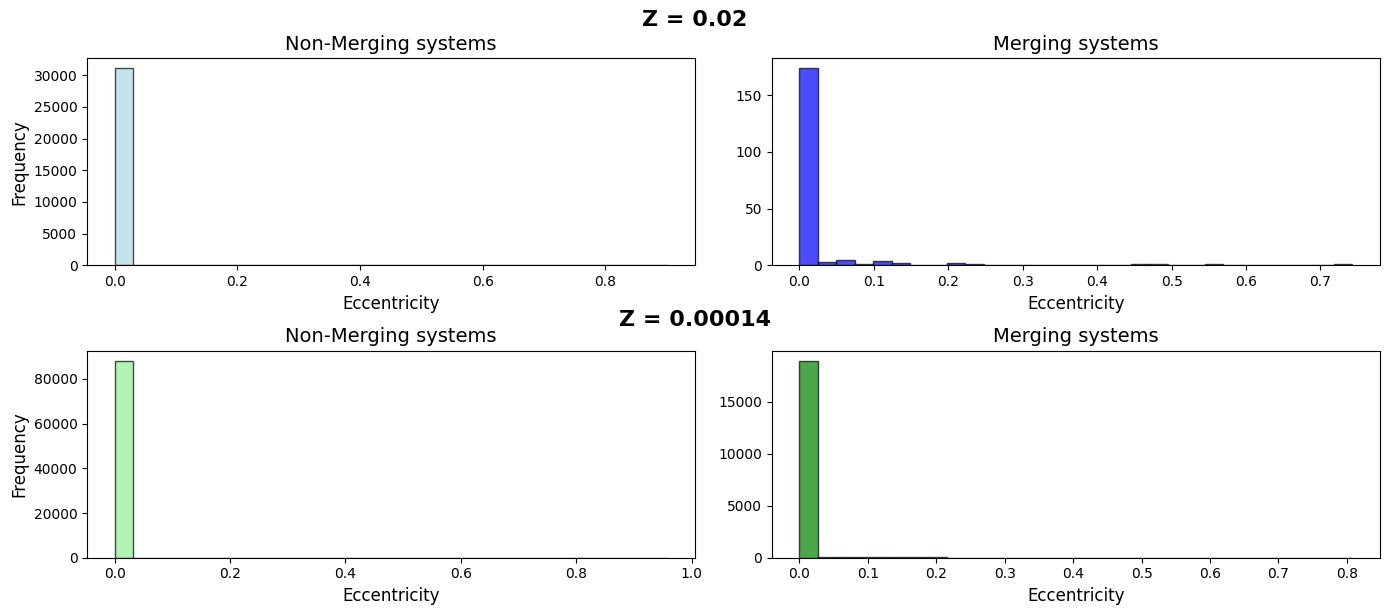

In [31]:
property_hist(df0, df1, 'Eccentricity')

The histogram clearly shows that almost all systems have (quasi-)circular orbits with small eccentricities. This behavior can be easily explained by tidal effects that circularize the orbit. However, at solar metallicity, some merging systems show higher eccentricities. This could be attributed to supernova kicks: when a supernova occurs, the compact remnant receives a natal kick that can alter the orbital properties, including the relative orbital velocity and the center of mass of the binary. These few systems may not have interacted significantly during their binary evolution and might have received lucky supernova kicks that increased their eccentricity, reducing in this way the gravitational wave merger time.

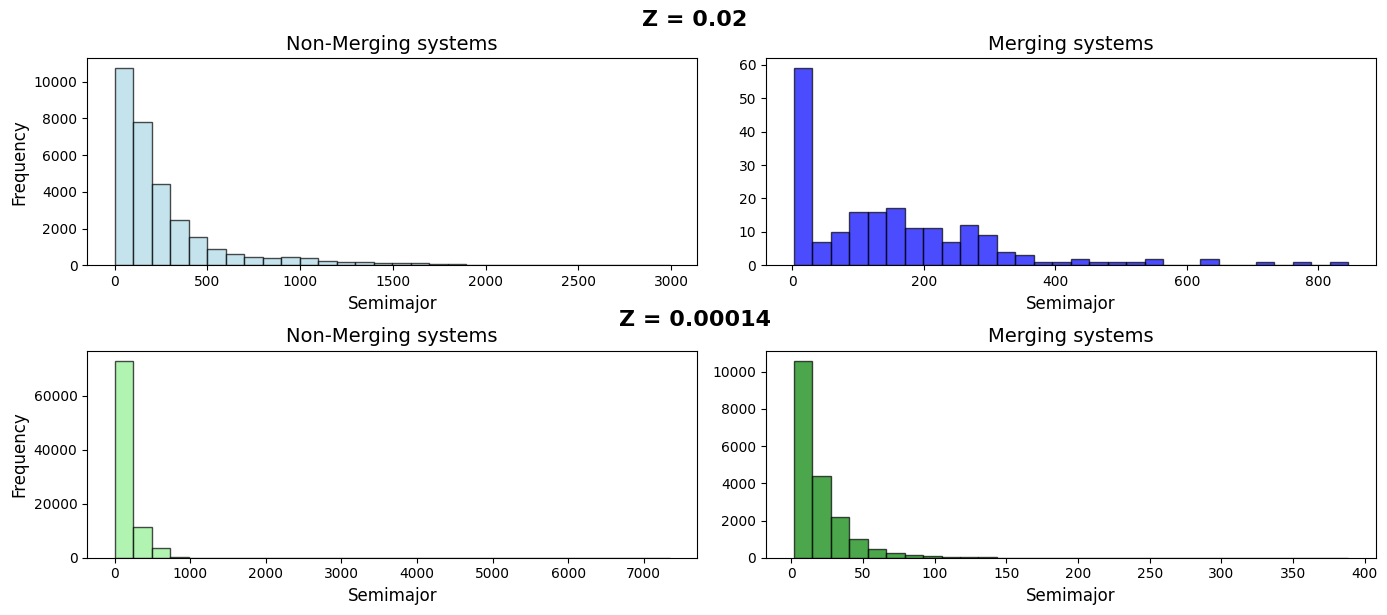

In [32]:
property_hist(df0, df1, 'Semimajor')

The histograms show that merging systems at Z=0.02 have a semimajor axis at the formation of the WR-BH binary $≲900 \ R_{\odot}$. At Z=0.00014
the semimajor has to be even smaller $≲150 \ R_{\odot}$. In general we can state that binaries need to have relatively tight orbits to allow the merger via gravitational-wave emission within a Hubble time.

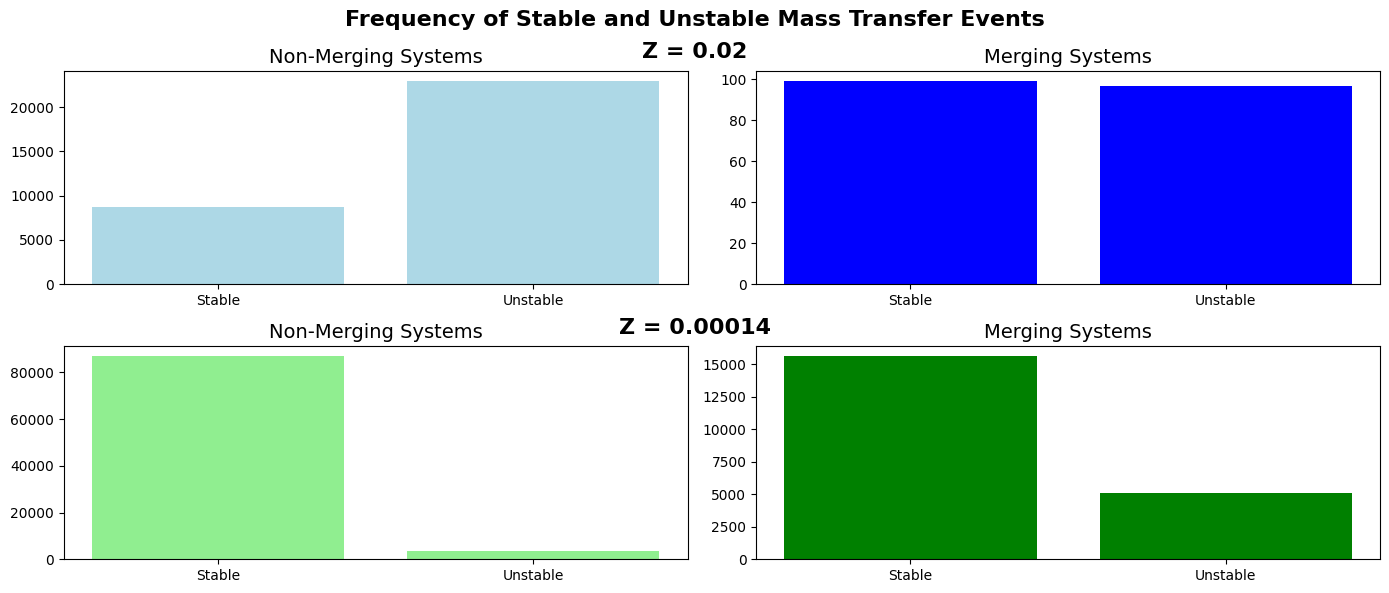

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(14, 6), sharey=False)

heights_0 = [[df0[df0['Merge']==0]['MTEvents_stable'].sum(), df0[df0['Merge']==0]['MTEvents_unstable'].sum()],
             [df0[df0['Merge']==1]['MTEvents_stable'].sum(), df0[df0['Merge']==1]['MTEvents_unstable'].sum()]]

heights_1 = [[df1[df1['Merge']==0]['MTEvents_stable'].sum(), df1[df1['Merge']==0]['MTEvents_unstable'].sum()],
             [df1[df1['Merge']==1]['MTEvents_stable'].sum(), df1[df1['Merge']==1]['MTEvents_unstable'].sum()]]

x_values = [0, 0.5]
labels = ['Stable', 'Unstable']

axes[0,0].bar(x_values, heights_0[0], width=0.4, color='lightblue')
axes[0,0].set_title('Non-Merging Systems', fontsize=14)
axes[0,1].bar(x_values, heights_0[1], width=0.4, color='blue')
axes[0,1].set_title('Merging Systems', fontsize=14)
axes[0,0].set_xticks(x_values)
axes[0,0].set_xticklabels(labels)
axes[0,1].set_xticks(x_values)
axes[0,1].set_xticklabels(labels)

axes[1,0].bar(x_values, heights_1[0], width=0.4, color='lightgreen')
axes[1,0].set_title('Non-Merging Systems', fontsize=14)
axes[1,1].bar(x_values, heights_1[1], width=0.4, color='green')
axes[1,1].set_title('Merging Systems', fontsize=14)
axes[1,0].set_xticks(x_values)
axes[1,0].set_xticklabels(labels)
axes[1,1].set_xticks(x_values)
axes[1,1].set_xticklabels(labels)


fig.suptitle('Frequency of Stable and Unstable Mass Transfer Events', fontsize=16, fontweight='bold')

fig.text(0.5, 0.91, 'Z = 0.02', ha='center', va='center', fontsize=16, fontweight='bold')
fig.text(0.5, 0.45, 'Z = 0.00014', ha='center', va='center', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

### 2.2 Features correlation

We know from theory that some features are correlated with each other. To confirm these correlations and examine the dataset, we will visualize it quantitatively. This step ensures that we avoid considering features that are already correlated when determining which features are important for predicting whether a system will merge.

We create a matrix to display the Spearman correlation for each pair of features. Spearman correlation ranges in the interval [-1,1] and it evaluates the strength and direction of a monotonic correlation of two features: 
- 1 indicates a perfect positive correlation
- -1 indicates a perfect negative correlation
- 0 indicates no correlation

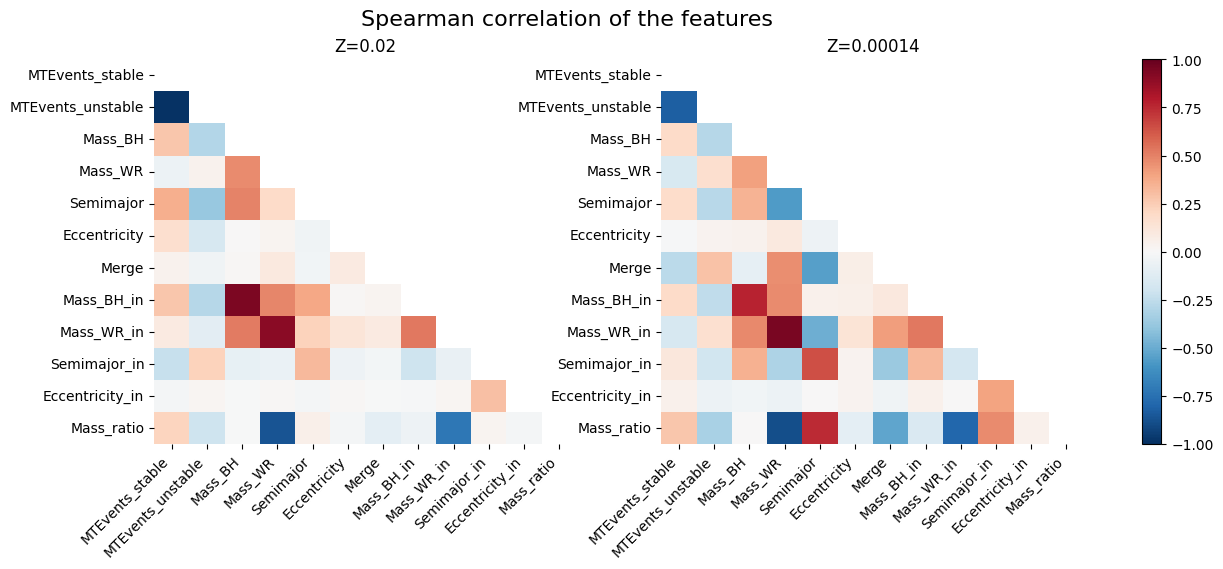

In [5]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
corr_matrix_0 = df0.iloc[:,1:].corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix_0, dtype=bool))
sns.heatmap(corr_matrix_0, mask=mask, cmap='RdBu_r', linecolor='w',ax=axs[0],vmin=-1, vmax=1,cbar=False)
axs[0].set_title('Z=0.02')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')

corr_matrix_1 = df1.iloc[:,1:].corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix_1, dtype=bool))
sns.heatmap(corr_matrix_1, mask=mask, cmap='RdBu_r', linecolor='w',ax=axs[1],vmin=-1, vmax=1,cbar=False)
axs[1].set_title('Z=0.00014')
axs[1].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
fig.colorbar(axs[0].collections[0], ax=axs)
fig.suptitle('Spearman correlation of the features',ha='center',fontsize=16,x=0.4)

plt.show()

Next, we calculate the point-biserial correlation for each feature with respect to the binary condition of whether the system merges or not.

This metric tells us the importance of each feature, providing an initial estimate of their relevance in the merging process. Additionally, we add a feature containing random data to serve as a benchmark. If a feature's correlation is comparable to that of the random data, it will be discarded from further analysis.

In [6]:
rand_0=pd.DataFrame({'rand_0': np.random.rand(len(df0))})
rand_1=pd.DataFrame({'rand_1': np.random.rand(len(df1))})

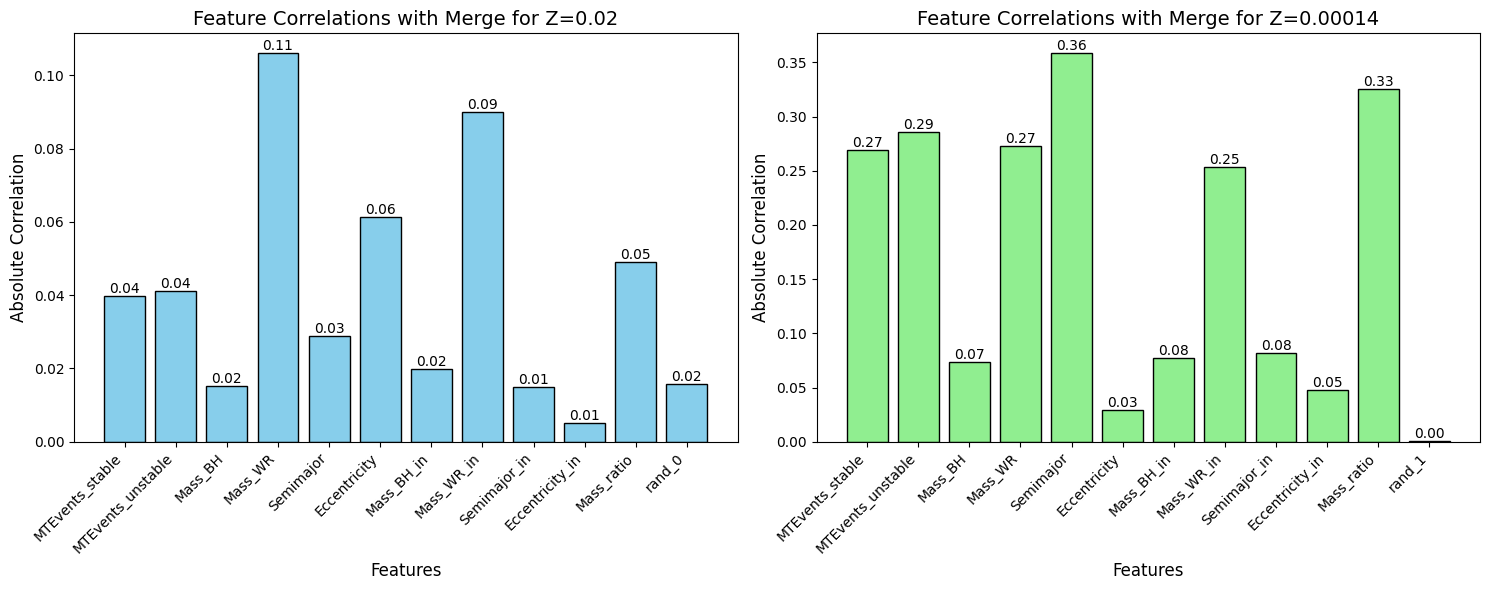

In [7]:
col0 = df0.drop(columns=["Merge",'ID'])
columns0 = pd.concat([col0, rand_0], axis=1)
correlation_dict0 = {}
for column in columns0:
    correlation = columns0[column].corr(df0['Merge'])
    correlation_dict0[column] = correlation
correlation_df0=pd.DataFrame(correlation_dict0,index=['Correlation']).T

col1 = df1.drop(columns=["Merge",'ID'])
columns1 = pd.concat([col1, rand_1], axis=1)
correlation_dict1 = {}
for column in columns1:
    correlation = columns1[column].corr(df1['Merge'])
    correlation_dict1[column] = correlation
correlation_df1=pd.DataFrame(correlation_dict1,index=['Correlation']).T

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot for the first bar chart
bars0 = axes[0].bar(x=range(len(abs(correlation_df0))), height=abs(correlation_df0['Correlation']), color='skyblue', edgecolor='black')
axes[0].set_xlabel('Features', fontsize=12)
axes[0].set_ylabel('Absolute Correlation', fontsize=12)
axes[0].set_title('Feature Correlations with Merge for Z=0.02', fontsize=14)
axes[0].set_xticks(range(len(abs(correlation_df0))))
axes[0].set_xticklabels(abs(correlation_df0).index, rotation=45, ha='right')

for bar in bars0:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

# Plot for the second bar chart
bars1 = axes[1].bar(x=range(len(abs(correlation_df1))), height=abs(correlation_df1['Correlation']), color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Features', fontsize=12)
axes[1].set_ylabel('Absolute Correlation', fontsize=12)
axes[1].set_title('Feature Correlations with Merge for Z=0.00014', fontsize=14)
axes[1].set_xticks(range(len(abs(correlation_df1))))
axes[1].set_xticklabels(abs(correlation_df1).index, rotation=45, ha='right')

for bar in bars1:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 3. Random Forest

We now implement a *Random Forest* algorithm to predict whether the BBHs selected systems merge via gravitational waves emission or not.

Firstly, we randomly shuffle the data to remove any possible correlation between consecutive measures. Then, we transform the semimajor axis-related features into a logarithmic scale, both for visualization purposes and to improve the algorithm's ability to classify the samples. For the same reason we standardize the data using the Z-score, by removing the mean and scaling to unit variance. 

After these preliminary operations, we split the data into a training set and a test set. The training set is used by the machine learning algorithm to learn which configurations result in a merging system, while the test set is used to give a measure of how well the algorithm has learned to distinguish the two classes.

In [5]:
def splitting_data(df, features, ratio=0.8):

    df = df.sample(frac=1)
    x = df[features].copy()
    
    #### setting Semimajor in log scale + normalizing 
    
    if 'Semimajor' in features:
        x['Semimajor'] = np.log10(x['Semimajor'])
    elif 'Semimajor_in' in features:
            x['Semimajor_in'] = np.log10(x['Semimajor_in'])

    scaler = StandardScaler().fit(x)
    x = scaler.transform(x)
    
    x = pd.DataFrame(x, columns=features)
    y = df.Merge

    N= x.shape[0]
    N_train = int(ratio * N)
    
    x_train = x.iloc[:N_train].reset_index(drop=True)
    y_train = y.iloc[:N_train].reset_index(drop=True)
    x_test = x.iloc[N_train:].reset_index(drop=True)
    y_test = y.iloc[N_train:].reset_index(drop=True)
    
    return(x_train, y_train, x_test, y_test, scaler)

We define a grid search on the number of trees the forest should contain and the maximum depth, i.e. the maximum number of layers in the decision trees. We use as score parameter the validation accuracy. 

In [8]:
def grid_search(param_grid, x_train, y_train, class_weight={0:1, 1:1}):
    RF = RandomForestClassifier(criterion='gini', class_weight=class_weight) 
    search = GridSearchCV(estimator=RF, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    results = search.fit(x_train, y_train)
    df_results = pd.DataFrame(results.cv_results_)
    df_results['mean_fit_time'] = results.cv_results_['mean_fit_time']
    df_results = df_results[['rank_test_score','mean_fit_time','std_fit_time','params',
                            'mean_test_score','std_test_score']].sort_values(by='mean_test_score', ascending=False)
    best_params = df_results['params'][0]
    return(df_results, best_params)


### 3.1 Random forest on intermediate conditions 

We initially select the features that describe the intermediate state, i.e., at the formation of the BH-WR binary. 

In [10]:
features = ['MTEvents_stable', 'MTEvents_unstable', 'Mass_BH', 'Mass_WR', 'Semimajor', 'Eccentricity', 'Mass_ratio']

# metallicity Z = 0.02
x0_train, y0_train, x0_test, y0_test, scaler0 = splitting_data(df0, features)

# metallicity Z = 0.00014
x1_train, y1_train, x1_test, y1_test, scaler1 = splitting_data(df1, features)

In [11]:
print(f'Z=0.02: fraction of merging BBH is {df0[df0.Merge==1].count().iloc[0]} / {df0.size} = {df0[df0.Merge==1].count().iloc[0]/df0.size}')
print(f'Z=0.00014: fraction of merging BBH is {df1[df1.Merge==1].count().iloc[0]} / {df1.size} = {df1[df1.Merge==1].count().iloc[0]/df1.size}')

Z=0.02: fraction of merging BBH is 196 / 410735 = 0.00047719332416278136
Z=0.00014: fraction of merging BBH is 19328 / 1401725 = 0.013788724607180438


By computing the ratio between merging systems and non-merging ones, we observe that the latter class is the majority one, leading to unbalanced datasets. In particular, the dataset with higher metallicity (Z=0.02) is more critical than the other (Z=0.00014). To tackle this problem, we will employ two different techniques: `RandomUnderSampler` and `SMOTE`.

#### 3.1.1 RandomUnderSampler

Employing the `RandomUnderSampler` package from the `imbalanced-learn` library we are able to randomly select samples from the majority class (non-merging systems) and remove them from the dataset. This results in a dataset where the minority class (merging systems) makes up a specific percentage of the total, as defined by the *sampling_strategy* parameter. 

We select a *sampling_strategy* of 0.015 so that the two datasets have a comparable ratio and at the same time we avoid loosing many samples from the training dataset.\
In addition, we specify the class_weight parameter to be 1 to 30 with respect to the two classes. This means that in evaluating what are the best parameters, the algorithm gives to the minority class 30 times more importance than the majority one, helping to address the class imbalance. These values are selected as they provide the best performances. 

With the results obtained from the grid search we specify our final algorithm, fitting it to our training data and computing the predicted label for the test set. 

In [12]:
############ Z=0.02

rus = RandomUnderSampler(sampling_strategy=0.015)
x0_train, y0_train = rus.fit_resample(x0_train, y0_train)

param_grid0 = {'n_estimators': [30, 60, 80, 100], 'max_depth': [3, 5, 7]}
class_weight = {0:1, 1:30}
df0_results, best_params0 = grid_search(param_grid0, x0_train, y0_train, class_weight=class_weight)

best_RF0 = RandomForestClassifier(**best_params0, criterion='gini', n_jobs=-1, class_weight=class_weight)
best_RF0.fit(x0_train, y0_train)

pred0_test = best_RF0.predict(x0_test)
pred0_train = best_RF0.predict(x0_train)

f1 = f1_score(y0_test, pred0_test)

print('------- Metallicity 0.02 ------- \n')
print("Best Parameters: \n", best_params0)
print("Errors={:.2f}%, Accuracy={:.3f}".format(100*(1-best_RF0.score(x0_test, y0_test)), best_RF0.score(x0_test, y0_test)))
print(f"F1 score={f1:.3f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


------- Metallicity 0.02 ------- 

Best Parameters: 
 {'max_depth': 3, 'n_estimators': 30}
Errors=10.75%, Accuracy=0.893
F1 score=0.063


For what concerns the Z=0.0014 dataset, we only need to act on the class weight parameter. 

In [13]:
########### Z=0.00014

param_grid1 = {'n_estimators': [30, 60, 80, 100], 'max_depth': [3, 5, 7]}
class_weight = {0:1, 1:30}

df1_results, best_params1 = grid_search(param_grid1, x1_train, y1_train, class_weight=class_weight)

best_RF1 = RandomForestClassifier(**best_params1, criterion='gini', n_jobs=-1, class_weight=class_weight)
fit1 = best_RF1.fit(x1_train,y1_train)

pred1_test = best_RF1.predict(x1_test)
pred1_train = best_RF1.predict(x1_train)

f1 = f1_score(y1_test, pred1_test)

print('------- Metallicity 0.00014 ------- \n')
print("Best Parameters: \n", best_params1)
print("Metallicity 0.00014: Errors={:.2f}%, Accuracy ={:.3f}".format(100*(1-best_RF1.score(x1_test, y1_test)), best_RF1.score(x1_test, y1_test)))
print(f"F1 score={f1:.3f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
------- Metallicity 0.00014 ------- 

Best Parameters: 
 {'max_depth': 3, 'n_estimators': 30}
Metallicity 0.00014: Errors=18.70%, Accuracy =0.813
F1 score=0.659


Accuracy alone is not sufficient to evaluate the performance of the random forest algorithm, especially given the imbalance in the two classes. For that reason, we evaluate the confusion matrices resulting from the predictions on both the training set and the test set.


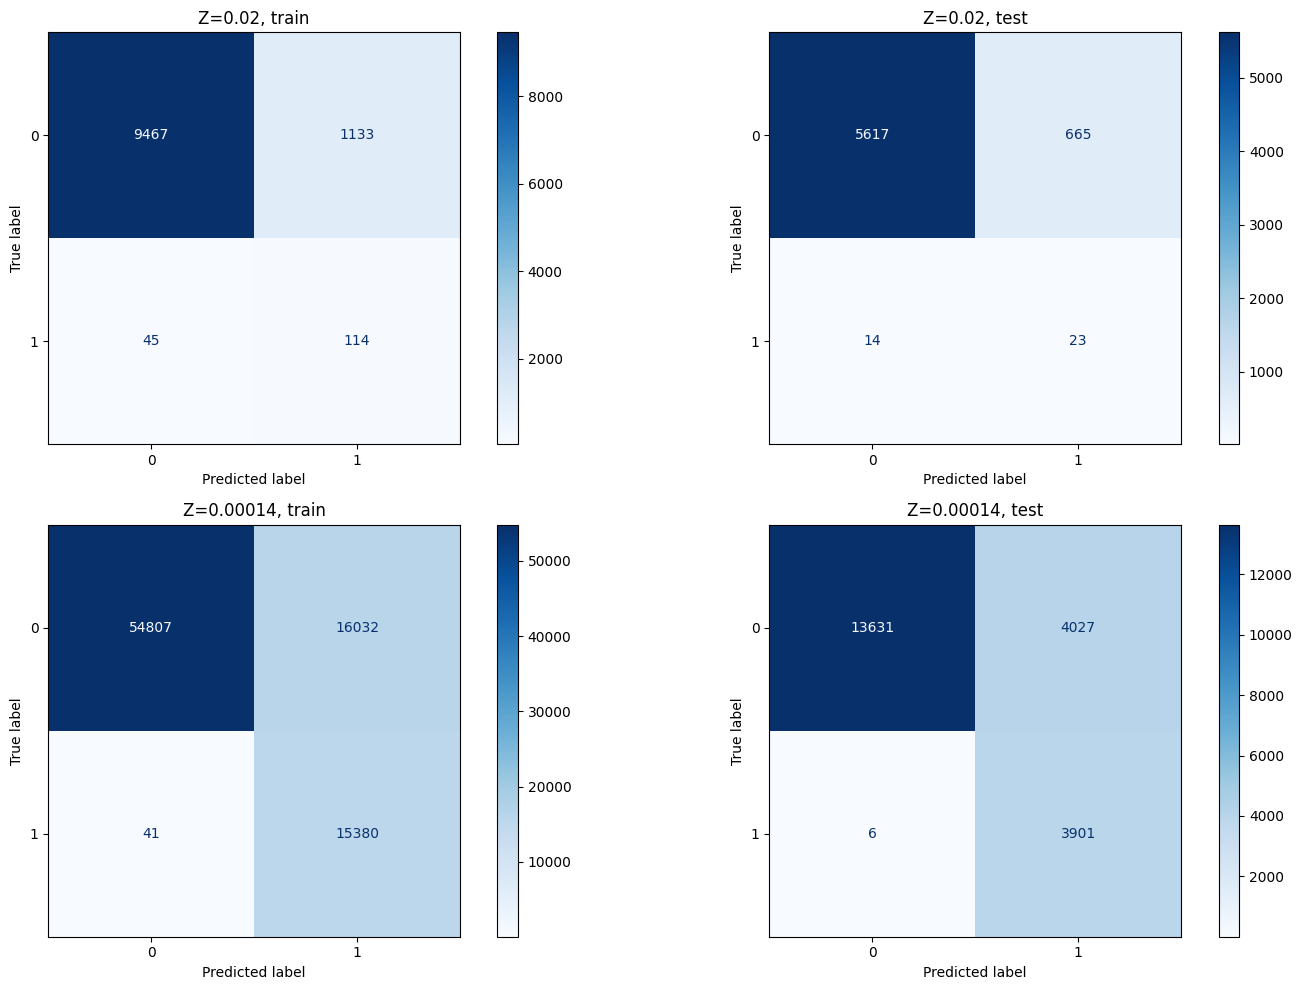

In [14]:
cm_0_train=confusion_matrix(y0_train,pred0_train)
cm_0_test=confusion_matrix(y0_test,pred0_test)
cm_1_train=confusion_matrix(y1_train,best_RF1.predict(x1_train))
cm_1_test=confusion_matrix(y1_test,best_RF1.predict(x1_test))

fig,ax=plt.subplots(2,2,figsize=(15,10))
ConfusionMatrixDisplay(cm_0_train).plot(ax=ax[0, 0], cmap='Blues')
ConfusionMatrixDisplay(cm_0_test).plot(ax=ax[0, 1], cmap='Blues')
ConfusionMatrixDisplay(cm_1_train).plot(ax=ax[1, 0], cmap='Blues')
ConfusionMatrixDisplay(cm_1_test).plot(ax=ax[1, 1], cmap='Blues')
ax[0, 0].set_title('Z=0.02, train')
ax[0, 1].set_title('Z=0.02, test')
ax[1, 0].set_title('Z=0.00014, train')
ax[1, 1].set_title('Z=0.00014, test')

plt.tight_layout()
plt.show()

The results show that the predictions are generally good for both classes, with an acceptable number of false negatives considering the imbalance. Additionally, we observe that there is no overfitting, as the results obtained on the training set are comparable to those obtained on the test set.


Now we consider the 'feature importances', which measure the contribution of each feature in predicting the label of the sample. 

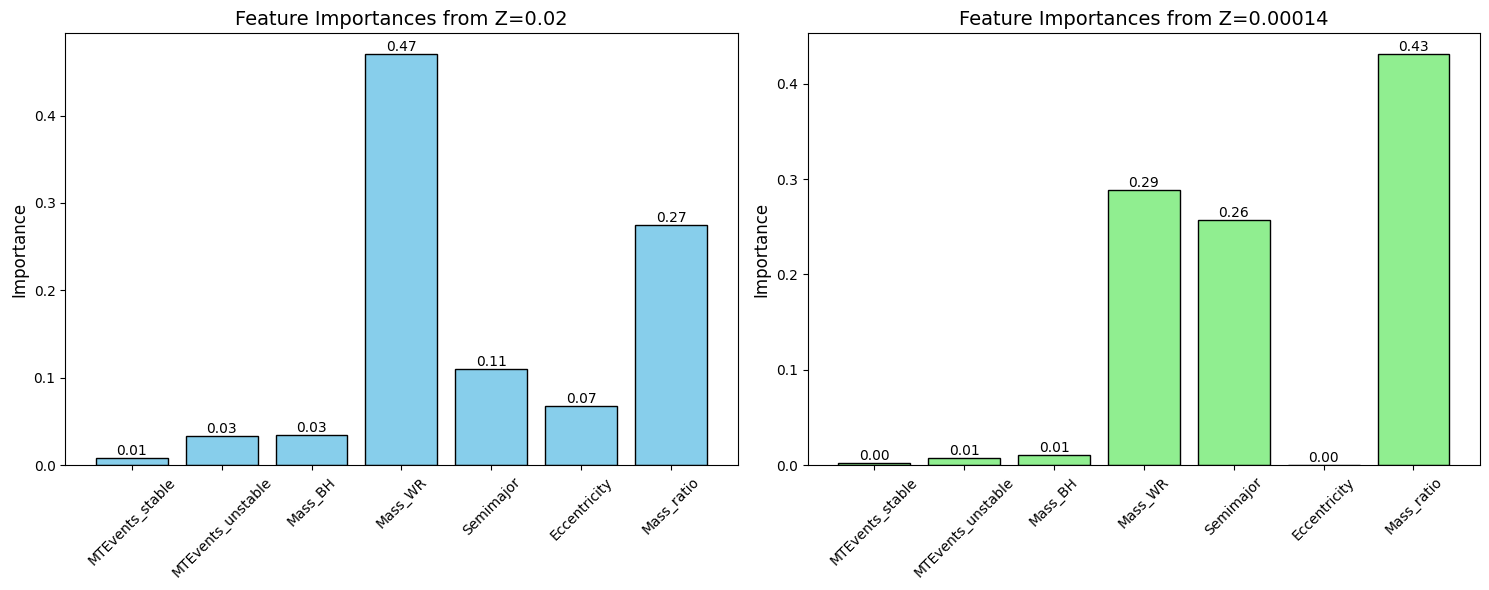

In [15]:
# Random Forest features importance 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))  

bars0 = axes[0].bar(features, best_RF0.feature_importances_, color='skyblue', edgecolor='black')
axes[0].set_ylabel('Importance', fontsize=12)
axes[0].set_title('Feature Importances from Z=0.02', fontsize=14)
axes[0].tick_params(axis='x', labelsize=10, rotation=45)

for bar in bars0:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)


bars1 = axes[1].bar(features, best_RF1.feature_importances_, color='lightgreen', edgecolor='black')
axes[1].set_ylabel('Importance', fontsize=12)
axes[1].set_title('Feature Importances from Z=0.00014', fontsize=14)
axes[1].tick_params(axis='x', labelsize=10, rotation=45)

for bar in bars1:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()  
plt.show()

For both datasets, the most important features in determining whether a system will merge are the mass of the Wolf-Rayet star, the semimajor axis, and the mass ratio between the black hole and the Wolf-Rayet star. 

The results obtained align with theoretical expectations: the mass of the Wolf-Rayet star is crucial in determining whether a system can evolve into a BBH. If the Wolf-Rayet star's mass is below a certain threshold (which varies with metallicity), it will not form a black hole but rather a neutron star. \
The semimajor is one of the key fetures as a smaller semimajor corresponds to an higher probability of merging.\
Regarding the number of mass transfer events, it is somewhat counterintuitive, as one might expect them to play a crucial role in determining whether a system will merge. However, it's important to note that we only selected systems that experience at least one mass transfer event. Therefore, this parameter is not particularly influential in distinguishing between merging and non-merging systems. We kept this parameter to investigate whether the stability of the mass transfer—whether it is stable (RLO) or unstable (CE)—affects the binary's evolutionary history. Our results suggest that this is not the case.


We plot the results, showing our samples in a dimensionally reduced feature space, distinguishing between false/true positives and negatives. In particular, we consider the three most important features for the training (Wolf-Rayet mass, semimajor axis, and mass ratio) and compare them two by two, considering all possible combinations.

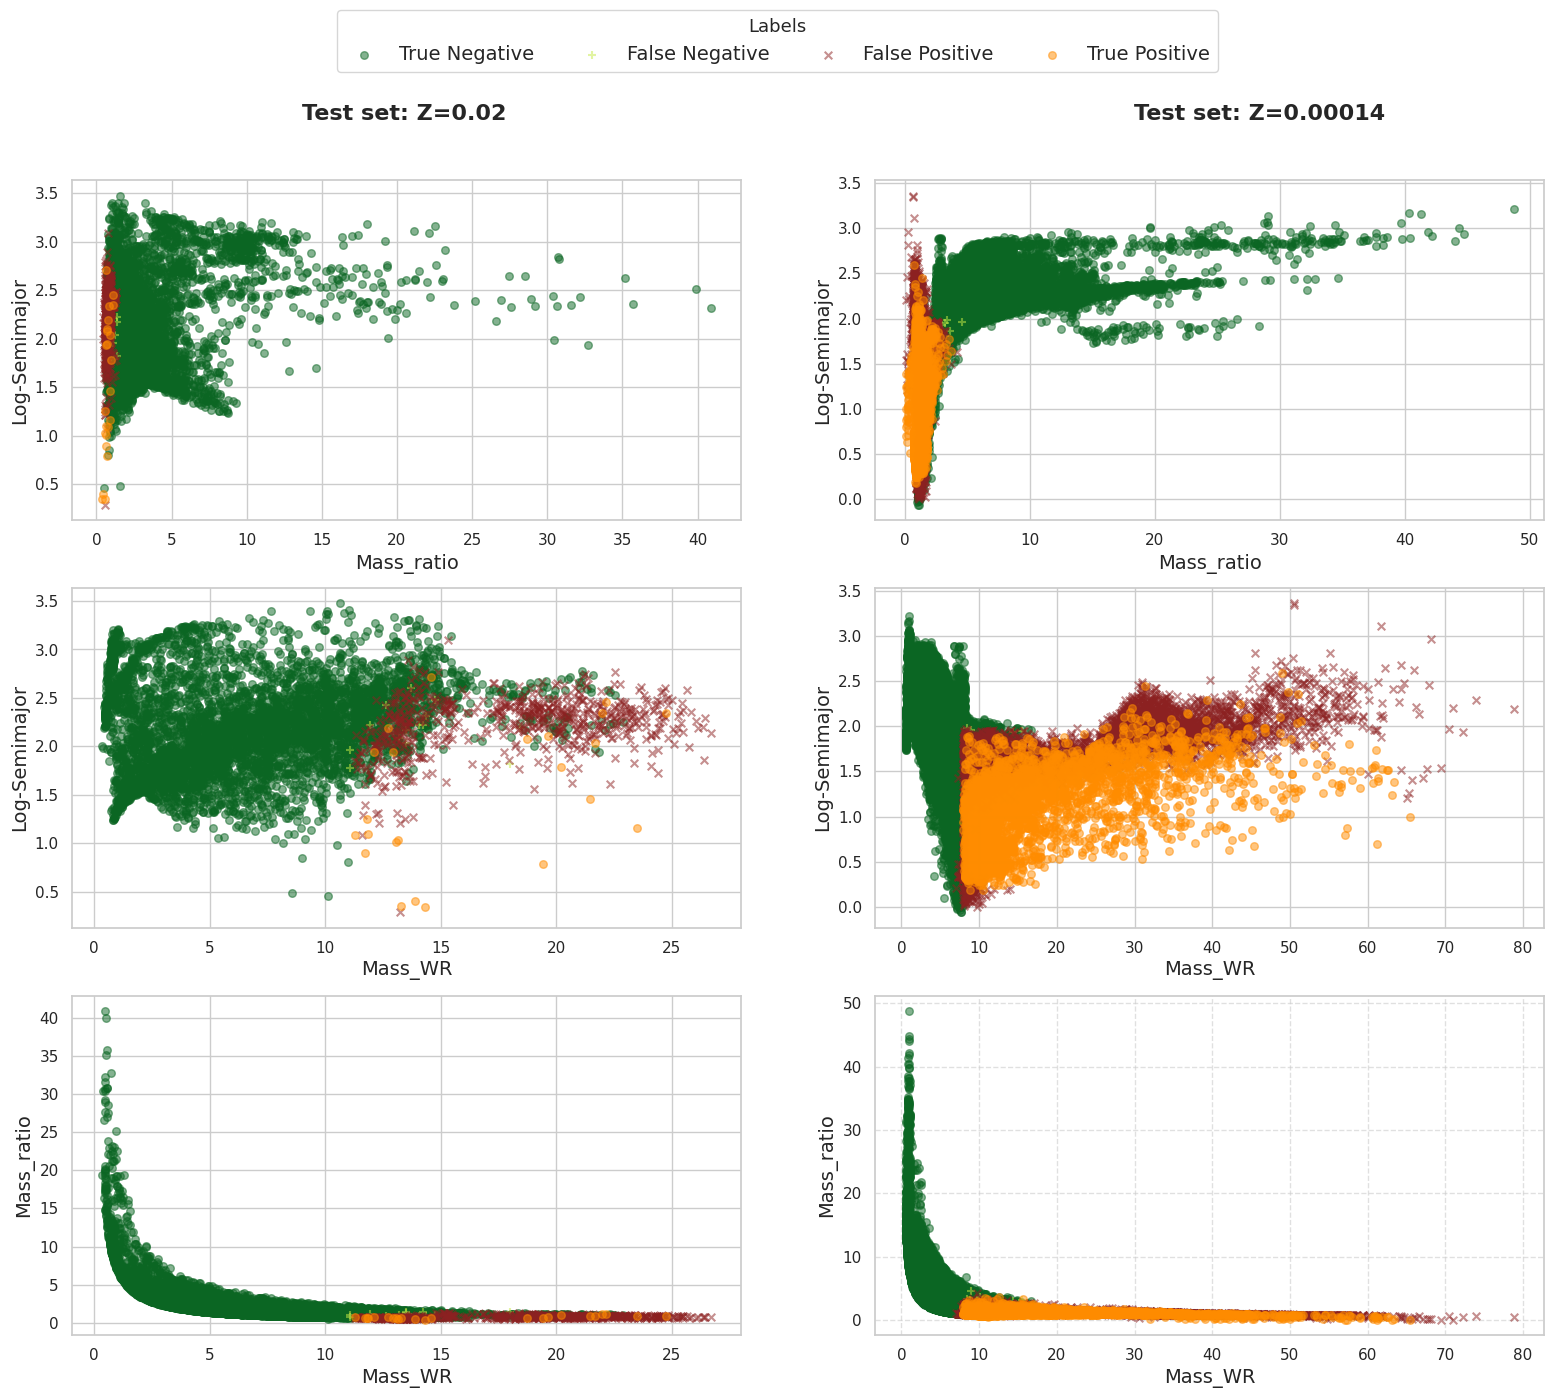

In [16]:
cmap = ListedColormap(['#0B6623', '#C7EA46', '#8C2121', 'darkorange'])
labels = ['True Negative', 'False Negative', 'False Positive', 'True Positive']
markers = {0: 'o', 1: '+', 2: 'x', 3: 'o'}

sns.set(style='whitegrid')

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(19, 15)) 

cols0 = x0_test.columns
x0_test = pd.DataFrame(scaler0.inverse_transform(x0_test), columns=cols0)
pair0_test = np.column_stack((y0_test, pred0_test))
label0_test = pair0_test[:, 0] + 2*pair0_test[:, 1]

cols1 = x1_test.columns
x1_test = pd.DataFrame(scaler1.inverse_transform(x1_test), columns=cols1)
pair1_test = np.column_stack((y1_test, pred1_test))
label1_test = pair1_test[:, 0] + 2*pair1_test[:, 1]


def plot_scatter(ax, x, y, labels, markers, cmap):
    for label, marker in markers.items():
        indices = (labels == label)
        ax.scatter(x[indices], y[indices], s=30, c=[cmap(label)], marker=marker, alpha=0.5)


plot_scatter(axes[0, 0], x0_test['Mass_ratio'], x0_test['Semimajor'], label0_test, markers, cmap)
axes[0, 0].set_xlabel('Mass_ratio', fontsize=14)
axes[0, 0].set_ylabel('Log-Semimajor', fontsize=14)

plot_scatter(axes[1, 0], x0_test['Mass_WR'], x0_test['Semimajor'], label0_test, markers, cmap)
axes[1, 0].set_xlabel('Mass_WR', fontsize=14)
axes[1, 0].set_ylabel('Log-Semimajor', fontsize=14)

plot_scatter(axes[2, 0], x0_test['Mass_WR'], x0_test['Mass_ratio'], label0_test, markers, cmap)
axes[2, 0].set_xlabel('Mass_WR', fontsize=14)
axes[2, 0].set_ylabel('Mass_ratio', fontsize=14)

plot_scatter(axes[0, 1], x1_test['Mass_ratio'], x1_test['Semimajor'], label1_test, markers, cmap)
axes[0, 1].set_xlabel('Mass_ratio', fontsize=14)
axes[0, 1].set_ylabel('Log-Semimajor', fontsize=14)

plot_scatter(axes[1, 1], x1_test['Mass_WR'], x1_test['Semimajor'], label1_test, markers, cmap)
axes[1, 1].set_xlabel('Mass_WR', fontsize=14)
axes[1, 1].set_ylabel('Log-Semimajor', fontsize=14)

plot_scatter(axes[2, 1], x1_test['Mass_WR'], x1_test['Mass_ratio'], label1_test, markers, cmap)
axes[2, 1].set_xlabel('Mass_WR', fontsize=14)
axes[2, 1].set_ylabel('Mass_ratio', fontsize=14)

fig.text(0.3, 0.92, 'Test set: Z=0.02', fontsize=16, fontweight='bold', ha='center')
fig.text(0.75, 0.92, 'Test set: Z=0.00014', fontsize=16, fontweight='bold', ha='center')



plt.figlegend(labels, loc='upper center', ncol=4, fontsize=14, title='Labels', title_fontsize='13')
plt.show()


For the Z=0.02 metallicity dataset the plots show a distinct region in which the merging phenomenon cannot happen. Because there are so few merging events in our dataset, in the other region both type of events are present, superimposing. Nevertheless, these plots show that there is a specific range of parameters for which we may expect the merging possible: outside of it the system would always not merge via GW emission. 

The same conclusion can be applied to the results obtained for the Z=0.0014 metallicity dataset. We can still clearly distinguish an area for which no merging happens. The number of samples superimposing is bigger as we are working on a larger dataset, this implies that there are many false positive.

As previously mentioned, it is evident for both datasets that there is a clear threshold in the mass of the Wolf-Rayet star. Below this limit, the Wolf-Rayet star will not form a black hole, thereby preventing the formation of binary black holes (BBHs). This threshold varies with metallicity: at Z=0.02 it is approximately $11-12 \ M_{\odot}$, while at Z=0.00014 it is approximately $7-8 \ M_{\odot}$. 

#### 3.1.2 SMOTE:

An alternative to removing samples from the majority class is to generate synthetic samples of the minority class. The `SMOTE` algorithm from the `imbalanced-learn` library is able to  do exactly this. It works by selecting regions of samples that are close in the feature space and creating new samples in that region. The advantadge of this approach is that we do not lose any valuable information from the majority class. In addition to that, this technique allows the model to better understand and learn the characteristics of the minority class, leading to improved prediction accuracy and more reliable classification results. However, a disadvantage is that the learning process is based on synthetic data rather than data derived from the actual simulation.

We select a _sampling_strategy_ of 0.3. We choose this higher value as with SMOTE there is no loss of samples from the training dataset. In principle we could select even an higher ratio, but this could possibly result in ambiguos syntetic sample if there is a strong overlap for the classes, as in our case.

In [ ]:
features = ['MTEvents_stable', 'MTEvents_unstable', 'Mass_BH', 'Mass_WR', 'Semimajor', 'Eccentricity', 'Mass_ratio']

# metallicity Z = 0.02
x0_train, y0_train, x0_test, y0_test, scaler0 = splitting_data(df0, features)

# metallicity Z = 0.00014
x1_train, y1_train, x1_test, y1_test, scaler1 = splitting_data(df1, features)

In [26]:
######### we specified the ratio: class 1 samples / class 0 samples = 0.3

smote = SMOTE(sampling_strategy=0.3)

x0_train, y0_train = smote.fit_resample(x0_train, y0_train)
param_grid0 = {'n_estimators': [30, 60, 80, 100], 'max_depth': [3, 5, 7]}

df0_results, best_params0 = grid_search(param_grid0, x0_train, y0_train)
best_RF0 = RandomForestClassifier(**best_params0, criterion='gini', n_jobs=-1)
fit0 = best_RF0.fit(x0_train, y0_train)

pred0_test = best_RF0.predict(x0_test)
pred0_train = best_RF0.predict(x0_train)

f1 = f1_score(y0_test, pred0_test)

print('------- Metallicity 0.02 ------- \n')
print("Best Parameters: \n", best_params0)
print("Errors={:.2f}%, Accuracy={:.3f}".format(100*(1-best_RF0.score(x0_test, y0_test)), best_RF0.score(x0_test, y0_test)))
print(f"F1 score={f1:.3f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
------- Metallicity 0.02 ------- 

Best Parameters: 
 {'max_depth': 3, 'n_estimators': 30}
Errors=2.28%, Accuracy=0.977
F1 score=0.234


In [27]:
x1_train, y1_train = smote.fit_resample(x1_train, y1_train)
param_grid1 = {'n_estimators': [30, 60, 80, 100], 'max_depth': [3, 5, 7]}

df1_results, best_params1 = grid_search(param_grid1, x1_train, y1_train)
best_RF1 = RandomForestClassifier(**best_params1, criterion='gini', n_jobs=-1)
fit1 = best_RF1.fit(x1_train, y1_train)

pred1_test = best_RF1.predict(x1_test)
pred1_train = best_RF1.predict(x1_train)

f1 = f1_score(y1_test, pred1_test)

print('------- Metallicity 0.02 ------- \n')
print("Best Parameters: \n", best_params1)
print("Errors={:.2f}%, Accuracy={:.3f}".format(100*(1-best_RF1.score(x1_test, y1_test)), best_RF1.score(x1_test, y1_test)))
print(f"F1 score={f1:.3f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
------- Metallicity 0.02 ------- 

Best Parameters: 
 {'max_depth': 3, 'n_estimators': 30}
Errors=5.84%, Accuracy=0.942
F1 score=0.843


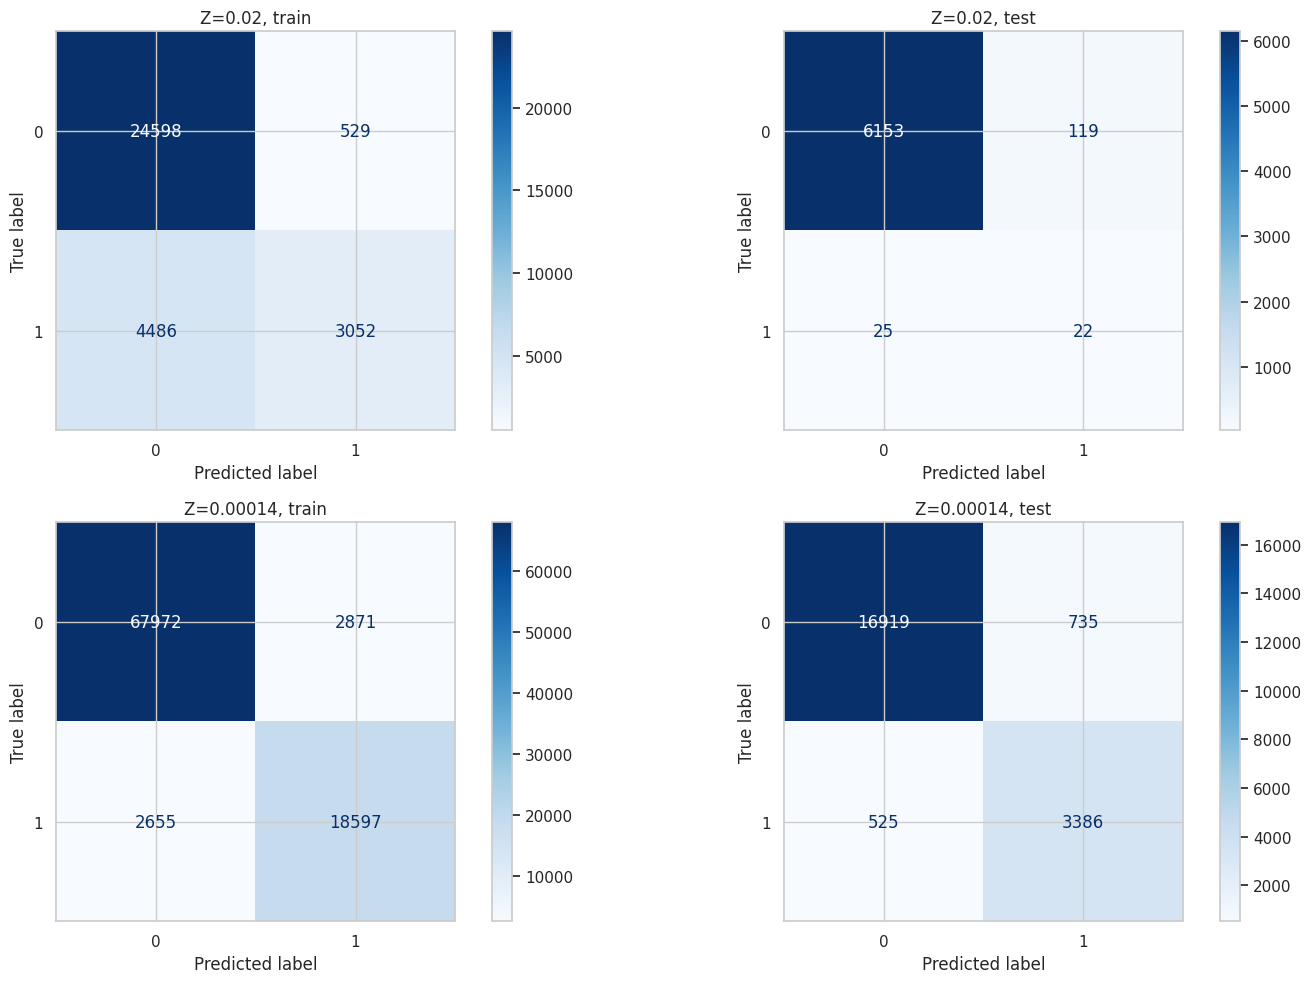

In [28]:
cm_0_train=confusion_matrix(y0_train,pred0_train)
cm_0_test=confusion_matrix(y0_test,pred0_test)
cm_1_train=confusion_matrix(y1_train,pred1_train)
cm_1_test=confusion_matrix(y1_test,pred1_test)

fig,ax=plt.subplots(2,2,figsize=(15,10))
ConfusionMatrixDisplay(cm_0_train).plot(ax=ax[0, 0], cmap='Blues')
ConfusionMatrixDisplay(cm_0_test).plot(ax=ax[0, 1], cmap='Blues')
ConfusionMatrixDisplay(cm_1_train).plot(ax=ax[1, 0], cmap='Blues')
ConfusionMatrixDisplay(cm_1_test).plot(ax=ax[1, 1], cmap='Blues')
ax[0, 0].set_title('Z=0.02, train')
ax[0, 1].set_title('Z=0.02, test')
ax[1, 0].set_title('Z=0.00014, train')
ax[1, 1].set_title('Z=0.00014, test')

plt.tight_layout()
plt.show()

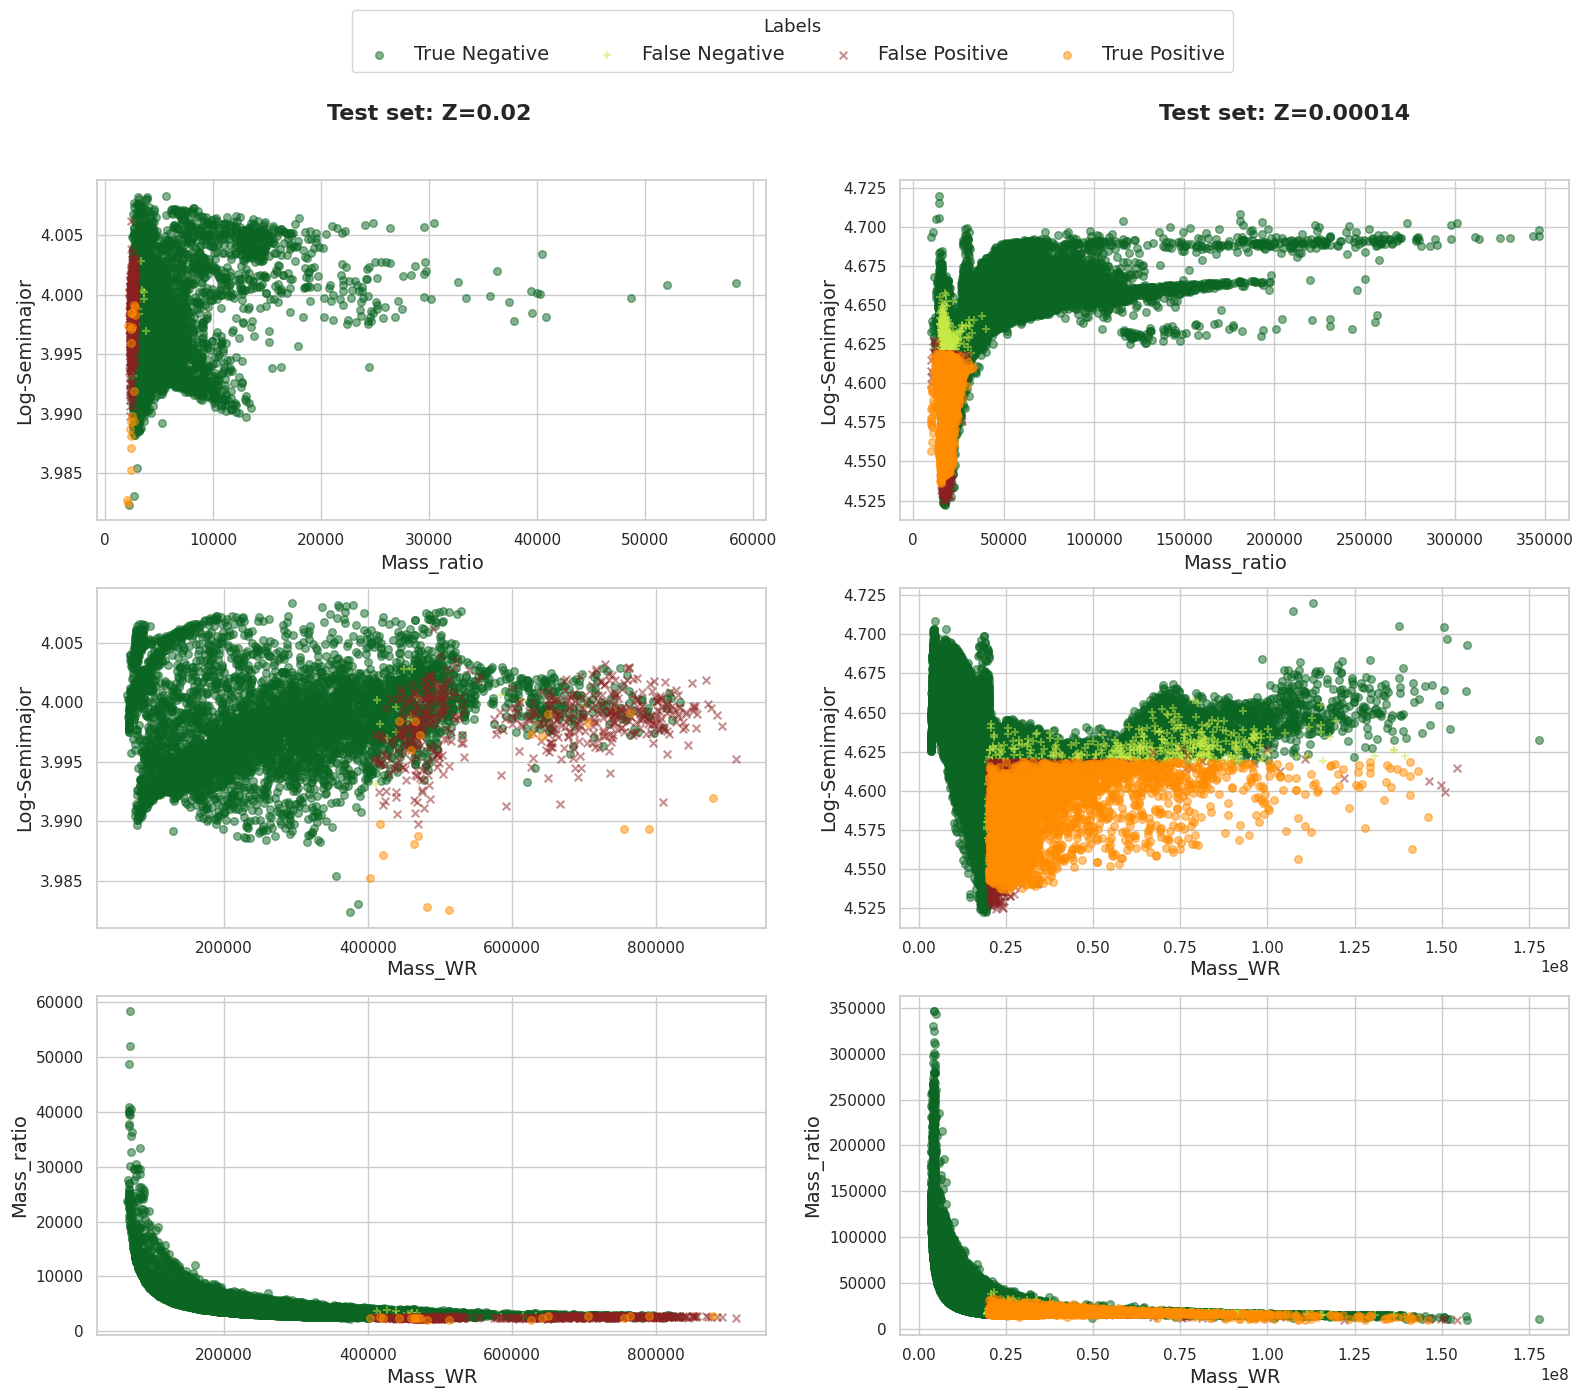

In [23]:
cmap = ListedColormap(['#0B6623', '#C7EA46', '#8C2121', 'darkorange'])
labels = ['True Negative', 'False Negative', 'False Positive', 'True Positive']
markers = {0: 'o', 1: '+', 2: 'x', 3: 'o'}

sns.set(style='whitegrid')

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(19, 15)) 

cols0 = x0_test.columns
x0_test = pd.DataFrame(scaler0.inverse_transform(x0_test), columns=cols0)
pair0_test = np.column_stack((y0_test, pred0_test))
label0_test = pair0_test[:, 0] + 2*pair0_test[:, 1]

cols1 = x1_test.columns
x1_test = pd.DataFrame(scaler1.inverse_transform(x1_test), columns=cols1)
pair1_test = np.column_stack((y1_test, pred1_test))
label1_test = pair1_test[:, 0] + 2*pair1_test[:, 1]

def plot_scatter(ax, x, y, labels, markers, cmap):
    for label, marker in markers.items():
        indices = (labels == label)
        ax.scatter(x[indices], y[indices], s=30, c=[cmap(label)], marker=marker, alpha=0.5)


plot_scatter(axes[0, 0], x0_test['Mass_ratio'], x0_test['Semimajor'], label0_test, markers, cmap)
axes[0, 0].set_xlabel('Mass_ratio', fontsize=14)
axes[0, 0].set_ylabel('Log-Semimajor', fontsize=14)

plot_scatter(axes[1, 0], x0_test['Mass_WR'], x0_test['Semimajor'], label0_test, markers, cmap)
axes[1, 0].set_xlabel('Mass_WR', fontsize=14)
axes[1, 0].set_ylabel('Log-Semimajor', fontsize=14)

plot_scatter(axes[2, 0], x0_test['Mass_WR'], x0_test['Mass_ratio'], label0_test, markers, cmap)
axes[2, 0].set_xlabel('Mass_WR', fontsize=14)
axes[2, 0].set_ylabel('Mass_ratio', fontsize=14)

plot_scatter(axes[0, 1], x1_test['Mass_ratio'], x1_test['Semimajor'], label1_test, markers, cmap)
axes[0, 1].set_xlabel('Mass_ratio', fontsize=14)
axes[0, 1].set_ylabel('Log-Semimajor', fontsize=14)

plot_scatter(axes[1, 1], x1_test['Mass_WR'], x1_test['Semimajor'], label1_test, markers, cmap)
axes[1, 1].set_xlabel('Mass_WR', fontsize=14)
axes[1, 1].set_ylabel('Log-Semimajor', fontsize=14)

plot_scatter(axes[2, 1], x1_test['Mass_WR'], x1_test['Mass_ratio'], label1_test, markers, cmap)
axes[2, 1].set_xlabel('Mass_WR', fontsize=14)
axes[2, 1].set_ylabel('Mass_ratio', fontsize=14)

fig.text(0.3, 0.92, 'Test set: Z=0.02', fontsize=16, fontweight='bold', ha='center')
fig.text(0.75, 0.92, 'Test set: Z=0.00014', fontsize=16, fontweight='bold', ha='center')

plt.figlegend(labels, loc='upper center', ncol=4, fontsize=14, title='Labels', title_fontsize='13')
plt.show()

We observe distinct outcomes from the two techniques. In the first scenario (RandomUnderSampler), it's possible to clearly delineate an area in the parameter space where merging events cannot occur. However, this method results in many non-merging events being misclassified as merging ones. Despite this, it is not an issue if our goal is to identify a region that can be excluded from analysis in the stellar evolution code.

On the contrary, the second technique (SMOTE) is more effective for defining an area with a high probability of merging events. The drawback, however, is that it discards some actual merging events, misclassifying them as non-merging. Overall, this algorithm sems to be more precise in determining merging BBHs. We can clearly observe again that the dataset at Z=0.02 is the most problematic, as both techniques have difficulties in identifying the few merging systems. 

### 3.2 Random forest on initial conditions 

We repeat the same procedure, this time selecting only the initial conditions as features, to evaluate whether these alone can determine if a system merges via the emission of gravitational waves. 

Despite the initially lower absolute correlations of *Semimajor_in* and *Eccentricity_in* compared to the random feature in the Z=0.02 dataset, we have decided to retain them in our analysis. This decision is justified by their relatively higher importance in the other dataset, which is less unbalanced and therefore more reliable.

In [20]:
features_in = ['Mass_BH_in', 'Mass_WR_in', 'Semimajor_in', 'Eccentricity_in']

# metallicity Z = 0.02
x0_train, y0_train, x0_test, y0_test, scaler0 = splitting_data(df0, features_in)

# metallicity Z = 0.00014
x1_train, y1_train, x1_test, y1_test, scaler1 = splitting_data(df1, features_in)

#### 3.2.1 RandomUnderSampler

Setting an higher weight for minority class and randomly removing samples from majority class:

In [8]:
#Grid search and learning over Z=0.02 dataset, using RandomUnderSampler technique

rus = RandomUnderSampler(sampling_strategy=0.015)
x0_train, y0_train = rus.fit_resample(x0_train, y0_train)

param_grid0 = {'n_estimators': [30, 60, 80, 100], 'max_depth': [3, 5, 7]}
class_weight = {0:1, 1:30}
df0_results, best_params0 = grid_search(param_grid0, x0_train, y0_train, class_weight=class_weight)

best_RF0 = RandomForestClassifier(**best_params0, criterion='gini', n_jobs=-1, class_weight=class_weight)
best_RF0.fit(x0_train, y0_train)

pred0_test = best_RF0.predict(x0_test)
pred0_train = best_RF0.predict(x0_train)

f1 = f1_score(y0_test, pred0_test)

print('------- Metallicity 0.02 ------- \n')
print("Best Parameters: \n", best_params0)
print("Errors={:.2f}%, Accuracy={:.3f}".format(100*(1-best_RF0.score(x0_test, y0_test)), best_RF0.score(x0_test, y0_test)))
print(f"F1 score={f1:.3f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
------- Metallicity 0.02 ------- 

Best Parameters: 
 {'max_depth': 3, 'n_estimators': 30}
Errors=14.12%, Accuracy=0.859
F1 score=0.028


In [9]:
# Grid search and learning over Z=0.0014 dataset
param_grid1 = {'n_estimators': [30, 60, 80, 100], 'max_depth': [3, 5, 7]}
class_weight = {0:1, 1:30}

df1_results, best_params1 = grid_search(param_grid1, x1_train, y1_train, class_weight=class_weight)

best_RF1 = RandomForestClassifier(**best_params1, criterion='gini', n_jobs=-1, class_weight=class_weight)
fit1 = best_RF1.fit(x1_train,y1_train)

pred1_test = best_RF1.predict(x1_test)
pred1_train = best_RF1.predict(x1_train)

print("Best Parameters:", best_params1)
print("Metallicity 0.00014: Errors={:.2f}%, Accuracy ={:.3f}".format(100*(1-best_RF1.score(x1_test, y1_test)), best_RF1.score(x1_test, y1_test)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 3, 'n_estimators': 30}
Metallicity 0.00014: Errors=34.67%, Accuracy =0.653


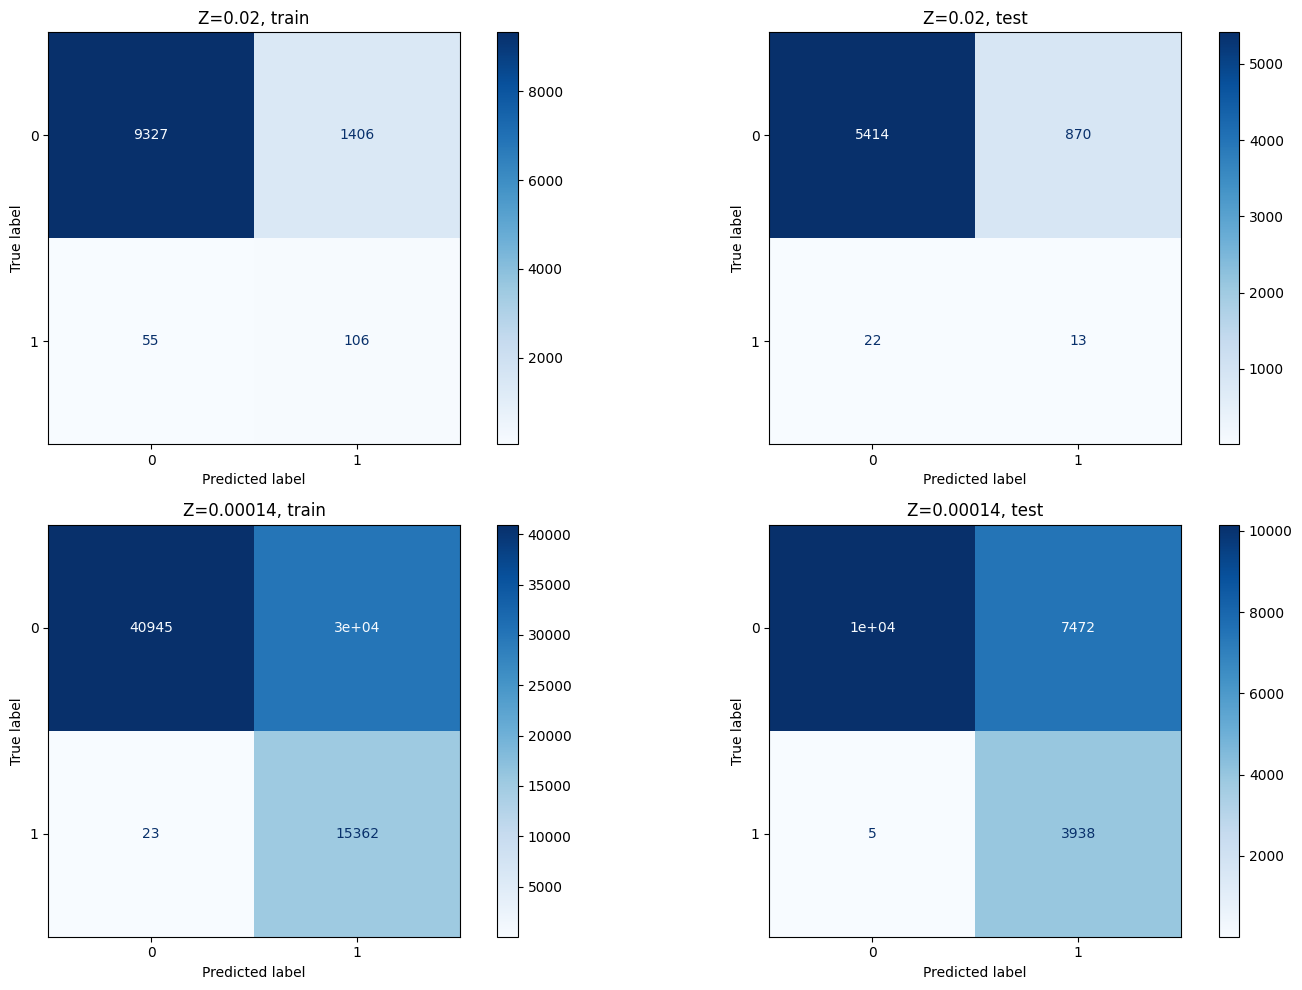

In [10]:
cm_0_train=confusion_matrix(y0_train,pred0_train)
cm_0_test=confusion_matrix(y0_test,pred0_test)
cm_1_train=confusion_matrix(y1_train,pred1_train)
cm_1_test=confusion_matrix(y1_test,pred1_test)

fig,ax=plt.subplots(2,2,figsize=(15,10))
ConfusionMatrixDisplay(cm_0_train).plot(ax=ax[0, 0], cmap='Blues')
ConfusionMatrixDisplay(cm_0_test).plot(ax=ax[0, 1], cmap='Blues')
ConfusionMatrixDisplay(cm_1_train).plot(ax=ax[1, 0], cmap='Blues')
ConfusionMatrixDisplay(cm_1_test).plot(ax=ax[1, 1], cmap='Blues')
ax[0, 0].set_title('Z=0.02, train')
ax[0, 1].set_title('Z=0.02, test')
ax[1, 0].set_title('Z=0.00014, train')
ax[1, 1].set_title('Z=0.00014, test')

plt.tight_layout()
plt.show()

The results obtained are consistent with our previous findings. This underlines the crucial role of imbalance in determining algorithm performance: the accuracy of the results has an upper limit, irrespective of the features used for training.

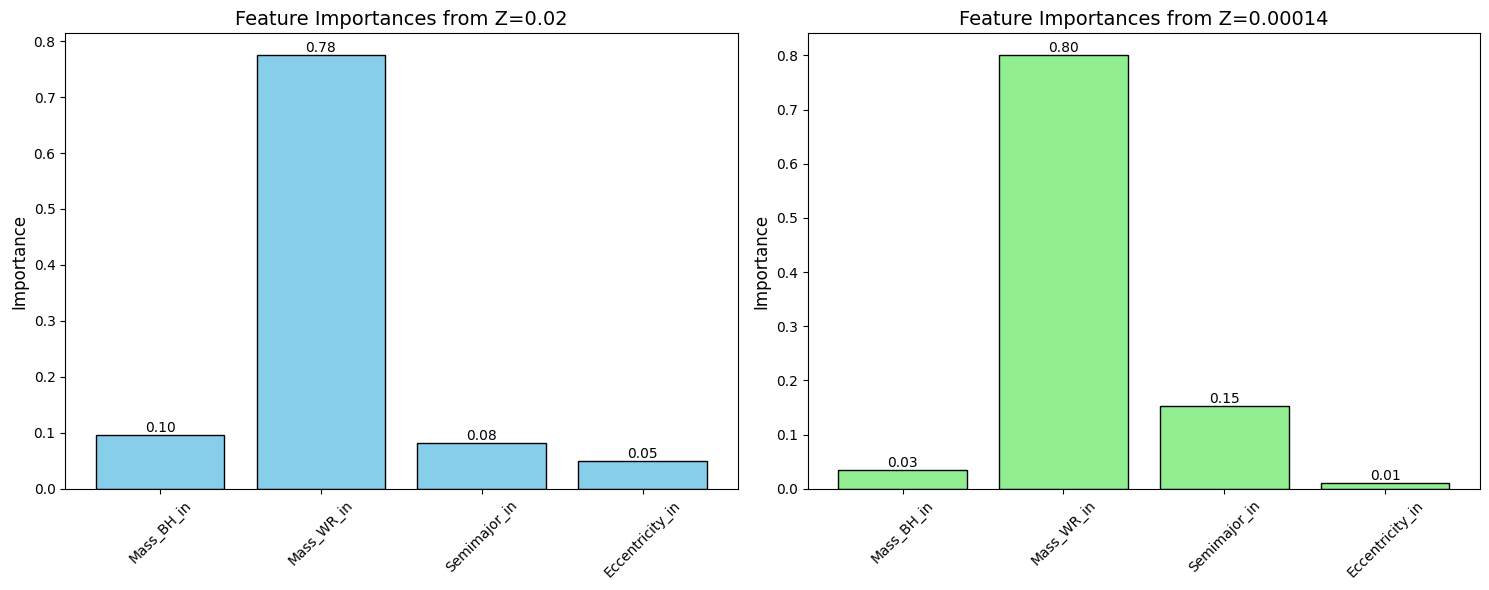

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))  

bars0 = axes[0].bar(features_in, best_RF0.feature_importances_, color='skyblue', edgecolor='black')
axes[0].set_ylabel('Importance', fontsize=12)
axes[0].set_title('Feature Importances from Z=0.02', fontsize=14)
axes[0].tick_params(axis='x', labelsize=10, rotation=45)

for bar in bars0:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)


bars1 = axes[1].bar(features_in, best_RF1.feature_importances_, color='lightgreen', edgecolor='black')
axes[1].set_ylabel('Importance', fontsize=12)
axes[1].set_title('Feature Importances from Z=0.00014', fontsize=14)
axes[1].tick_params(axis='x', labelsize=10, rotation=45)

for bar in bars1:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()  
plt.show()

The most significant factor in determining whether a binary star system will merge is evidently the initial mass of the star that subsequently evolves into a Wolf-Rayet star. The same considerations made in the previous section can be applied here.

With this result in mind, we proceed to illustrate how the merging phenomenon varies in relation to the initial mass of the star destined to become the Wolf-Rayet star and the initial semimajor axis of the system, which is the second most important feature.

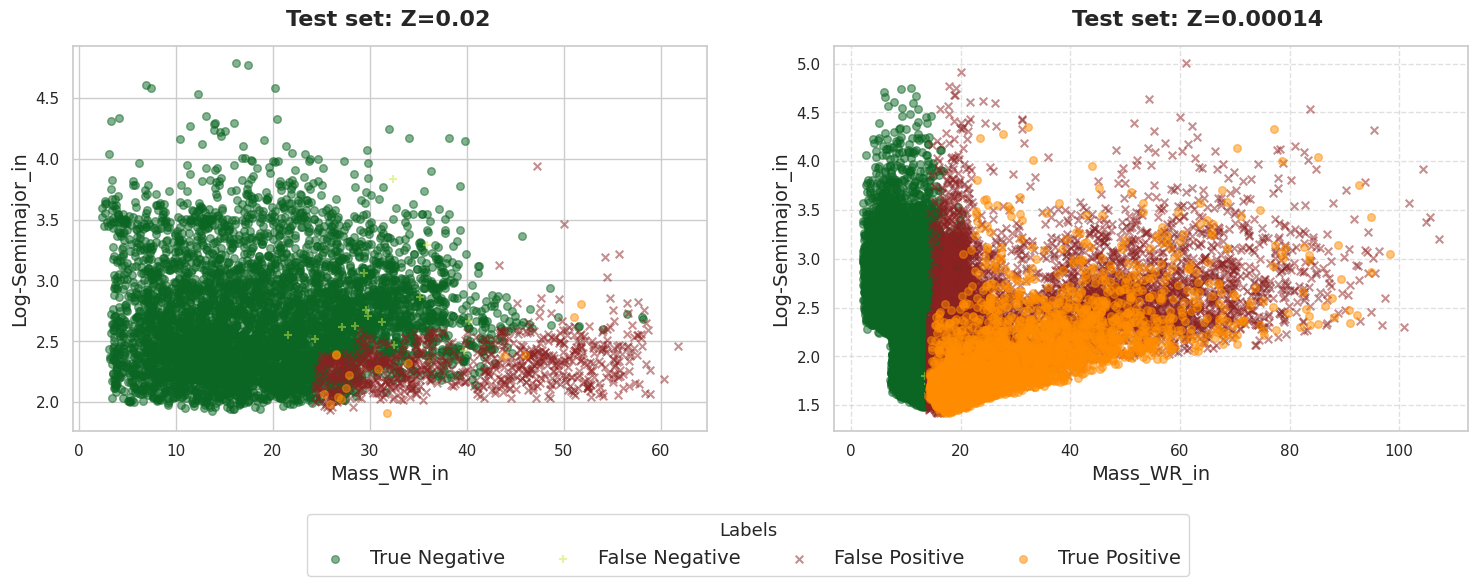

In [31]:
cmap = ListedColormap(['#0B6623', '#C7EA46', '#8C2121', 'darkorange'])
labels = ['True Negative', 'False Negative', 'False Positive', 'True Positive']
markers = {0: 'o', 1: '+', 2: 'x', 3: 'o'}

sns.set(style='whitegrid')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5)) 

cols0 = x0_test.columns
x0_test = pd.DataFrame(scaler0.inverse_transform(x0_test), columns=cols0)
pair0_test = np.column_stack((y0_test, pred0_test))
label0_test = pair0_test[:, 0] + 2*pair0_test[:, 1]

cols1 = x1_test.columns
x1_test = pd.DataFrame(scaler1.inverse_transform(x1_test), columns=cols1)
pair1_test = np.column_stack((y1_test, pred1_test))
label1_test = pair1_test[:, 0] + 2*pair1_test[:, 1]

plot_scatter(axes[0], x0_test['Mass_WR_in'], x0_test['Semimajor_in'], label0_test, markers, cmap)
axes[0].set_xlabel('Mass_WR_in', fontsize=14)
axes[0].set_ylabel('Log-Semimajor_in', fontsize=14)

plot_scatter(axes[1], x1_test['Mass_WR_in'], x1_test['Semimajor_in'], label1_test, markers, cmap)
axes[1].set_xlabel('Mass_WR_in', fontsize=14)
axes[1].set_ylabel('Log-Semimajor_in', fontsize=14)

fig.text(0.3, 0.92, 'Test set: Z=0.02', fontsize=16, fontweight='bold', ha='center')
fig.text(0.75, 0.92, 'Test set: Z=0.00014', fontsize=16, fontweight='bold', ha='center')

plt.grid(True, linestyle='--', alpha=0.6)

plt.figlegend(labels, loc='lower center', ncol=4, fontsize=14, title='Labels', title_fontsize='13', bbox_to_anchor=(0.5, -0.2))
plt.show()

We can clearly observe a distinct division between merging and non-merging areas, determined by the initial mass of the Wolf-Rayet (WR) star. At a metallicity of Z=0.02 systems with an initial WR star mass $≲ 25 \ M_{\odot}$ never merge, while at Z=0.0014 this threshold decreases to $17 - 18 \ M_{\odot}$.

#### 3.2.2 SMOTE

In [21]:
x0_train, y0_train = smote.fit_resample(x0_train, y0_train)

df0_results, best_params0 = grid_search(param_grid0, x0_train, y0_train)
best_RF0 = RandomForestClassifier(**best_params0, criterion='gini', n_jobs=-1)
fit0 = best_RF0.fit(x0_train, y0_train)

pred0_test = best_RF0.predict(x0_test)
pred0_train = best_RF0.predict(x0_train)

f1 = f1_score(y0_test, pred0_test)

print('------- Metallicity 0.02 ------- \n')
print("Best Parameters: \n", best_params0)
print("Errors={:.2f}%, Accuracy={:.3f}".format(100*(1-best_RF0.score(x0_test, y0_test)), best_RF0.score(x0_test, y0_test)))
print(f"F1 score={f1:.3f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
------- Metallicity 0.02 ------- 

Best Parameters: 
 {'max_depth': 3, 'n_estimators': 30}
Errors=10.82%, Accuracy=0.892
F1 score=0.055


In [22]:
x1_train, y1_train = smote.fit_resample(x1_train, y1_train)

df1_results, best_params1 = grid_search(param_grid1, x1_train, y1_train)
best_RF1 = RandomForestClassifier(**best_params1, criterion='gini', n_jobs=-1)
fit1 = best_RF1.fit(x1_train, y1_train)

pred1_test = best_RF1.predict(x1_test)
pred1_train = best_RF1.predict(x1_train)

f1 = f1_score(y1_test, pred1_test)

print('------- Metallicity 0.02 ------- \n')
print("Best Parameters: \n", best_params1)
print("Errors={:.2f}%, Accuracy={:.3f}".format(100*(1-best_RF1.score(x1_test, y1_test)), best_RF1.score(x1_test, y1_test)))
print(f"F1 score={f1:.3f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
------- Metallicity 0.02 ------- 

Best Parameters: 
 {'max_depth': 3, 'n_estimators': 30}
Errors=12.26%, Accuracy=0.877
F1 score=0.679


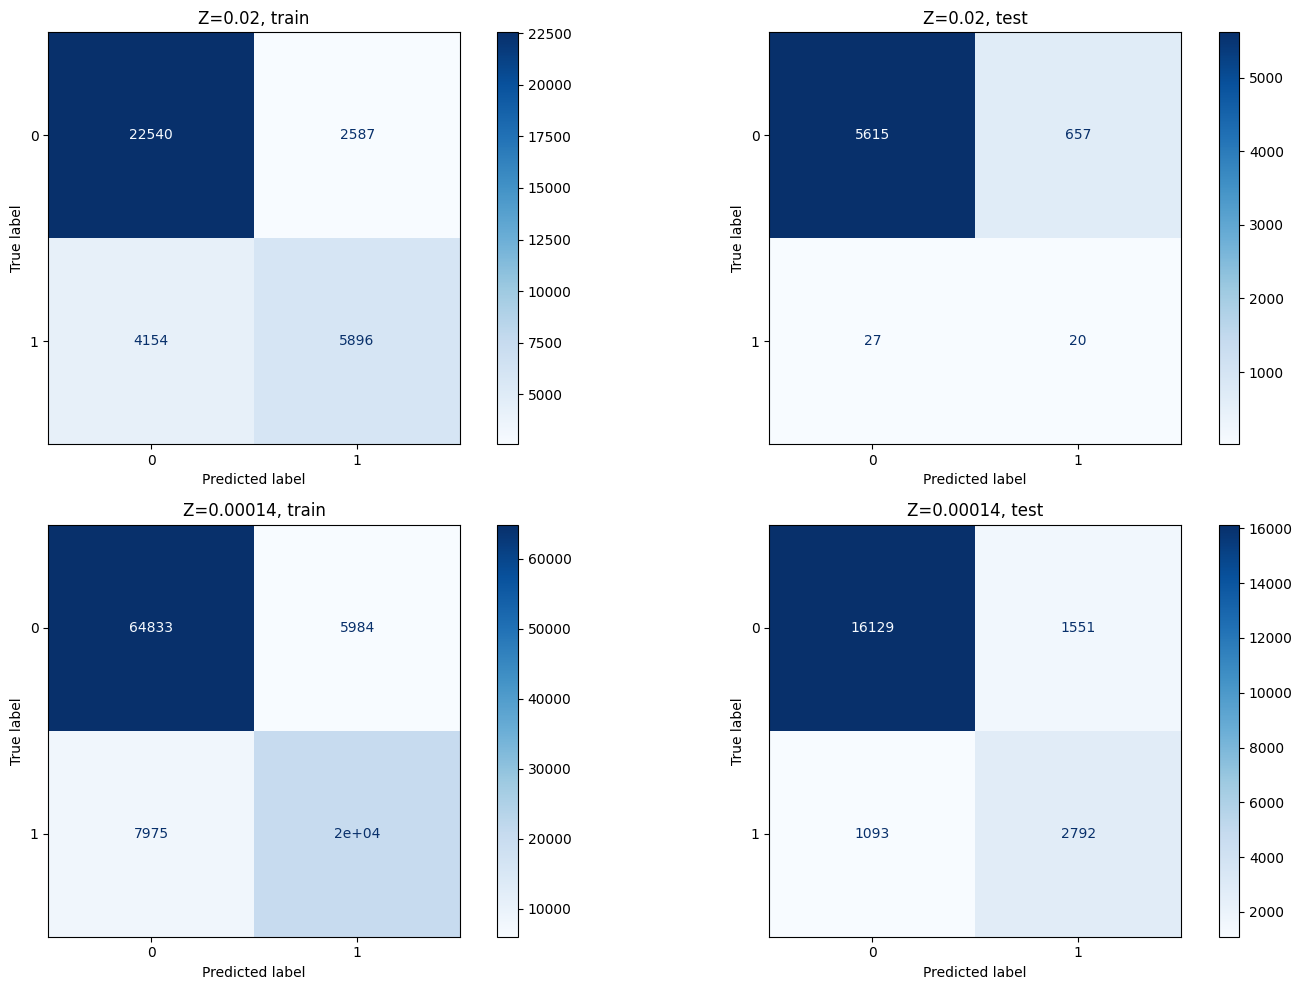

In [23]:
cm_0_train=confusion_matrix(y0_train,pred0_train)
cm_0_test=confusion_matrix(y0_test,pred0_test)
cm_1_train=confusion_matrix(y1_train,pred1_train)
cm_1_test=confusion_matrix(y1_test,pred1_test)

fig,ax=plt.subplots(2,2,figsize=(15,10))
ConfusionMatrixDisplay(cm_0_train).plot(ax=ax[0, 0], cmap='Blues')
ConfusionMatrixDisplay(cm_0_test).plot(ax=ax[0, 1], cmap='Blues')
ConfusionMatrixDisplay(cm_1_train).plot(ax=ax[1, 0], cmap='Blues')
ConfusionMatrixDisplay(cm_1_test).plot(ax=ax[1, 1], cmap='Blues')
ax[0, 0].set_title('Z=0.02, train')
ax[0, 1].set_title('Z=0.02, test')
ax[1, 0].set_title('Z=0.00014, train')
ax[1, 1].set_title('Z=0.00014, test')

plt.tight_layout()
plt.show()

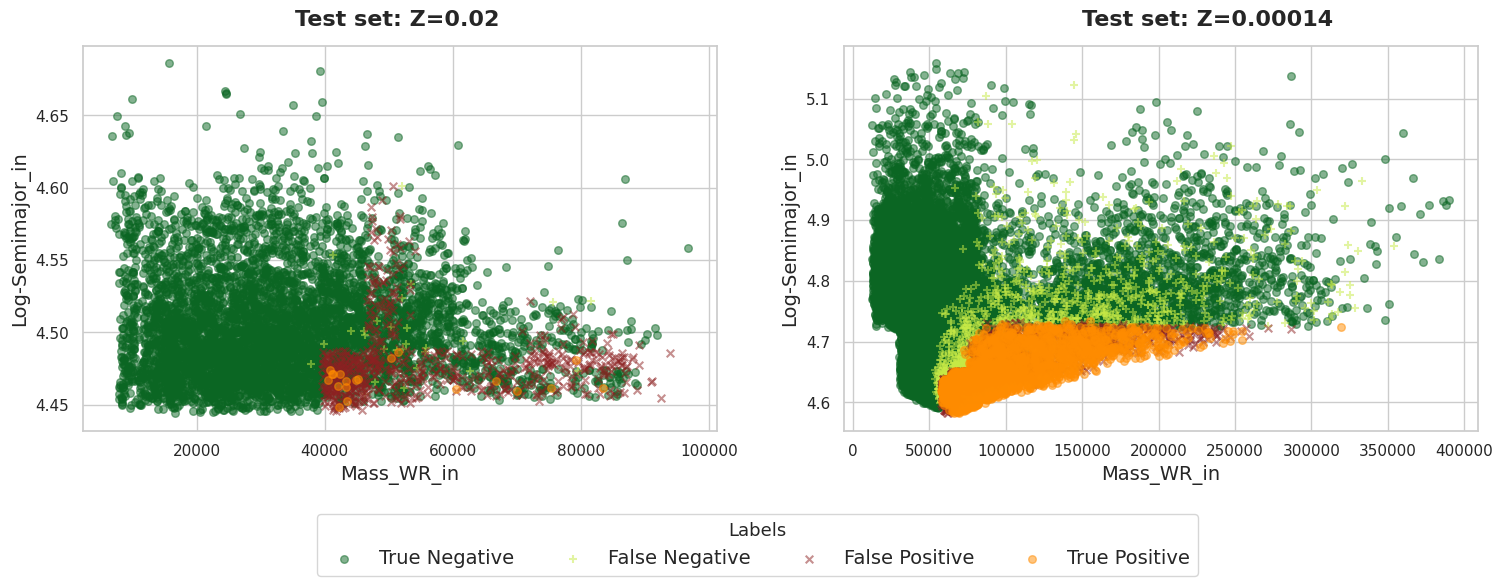

In [27]:
cmap = ListedColormap(['#0B6623', '#C7EA46', '#8C2121', 'darkorange'])
labels = ['True Negative', 'False Negative', 'False Positive', 'True Positive']
markers = {0: 'o', 1: '+', 2: 'x', 3: 'o'}

sns.set(style='whitegrid')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5)) 

cols0 = x0_test.columns
x0_test = pd.DataFrame(scaler0.inverse_transform(x0_test), columns=cols0)
pair0_test = np.column_stack((y0_test, pred0_test))
label0_test = pair0_test[:, 0] + 2*pair0_test[:, 1]

cols1 = x1_test.columns
x1_test = pd.DataFrame(scaler1.inverse_transform(x1_test), columns=cols1)
pair1_test = np.column_stack((y1_test, pred1_test))
label1_test = pair1_test[:, 0] + 2*pair1_test[:, 1]

def plot_scatter(ax, x, y, labels, markers, cmap):
    for label, marker in markers.items():
        indices = (labels == label)
        ax.scatter(x[indices], y[indices], s=30, c=[cmap(label)], marker=marker, alpha=0.5)

plot_scatter(axes[0], x0_test['Mass_WR_in'], x0_test['Semimajor_in'], label0_test, markers, cmap)
axes[0].set_xlabel('Mass_WR_in', fontsize=14)
axes[0].set_ylabel('Log-Semimajor_in', fontsize=14)

plot_scatter(axes[1], x1_test['Mass_WR_in'], x1_test['Semimajor_in'], label1_test, markers, cmap)
axes[1].set_xlabel('Mass_WR_in', fontsize=14)
axes[1].set_ylabel('Log-Semimajor_in', fontsize=14)

fig.text(0.3, 0.92, 'Test set: Z=0.02', fontsize=16, fontweight='bold', ha='center')
fig.text(0.75, 0.92, 'Test set: Z=0.00014', fontsize=16, fontweight='bold', ha='center')

plt.figlegend(labels, loc='lower center', ncol=4, fontsize=14, title='Labels', title_fontsize='13', bbox_to_anchor=(0.5, -0.2))
plt.show()

The results we obtain are similar to those obtained considering the "intermediate features". The algorithm have some difficulties in assignin correcltly which are the systems that merge, expecially for the Z=0.02 dataset, due to the imbalance between the two classes. Nevertheless, the classification of non-merging systems is good and also in this case we can clearly delineate an area in the parameter space where merging events cannot occur. The most important parameter in determining this region is obviously the initial mass of the star that will become a Wolf-Rayet. The main advantadge we can take from this result is that we now know what are the initial configurations for binary systems we should not consider if we want to run a simultation resulting in a merging system.

## Conlcusions

In this project, we focused on determining the conditions under which Wolf-Rayet - black hole binaries evolve into binary black holes that merge via emission of gravitational waves within the Hubble time. We selected specific initial and intermediate properties for study and implemented a Random Forest algorithm.

Given that we were dealing with an unbalanced dataset, we employed two different approaches to address this issue: RandomUndersampler and SMOTE.

Regarding the parameters at the formation of the WR-BH binary, we found that the most influential factors were the mass of the Wolf-Rayet star, the mass ratio, and the semimajor axis. These results align with our theoretical expectations. Similarly, for the initial parameters, we found that the mass of the progenitor star that becomes the WR star is the most critical feature in determining the likelihood of merging.

By analyzing two different datasets at Z=0.02 and Z=0.0014, we observed that while the importance of the parameters remained consistent, the thresholds distinguishing merging from non-merging regions changed. This can be explained by the different processes in stellar evolution and mass transfer events at varying metallicities.

Our goal was to identify a range in the parameter space that leads to the formation of merging BBHs. However, our conclusions suggest that determining such a range is challenging when the merging events are rare. Instead, it is easier to exclude regions where we know (both from theory and from the implemented algorithm) that the systems will not merge. This exclusion can be useful for identifying regions that can be omitted from analysis in stellar evolution codes when focusing on BBHs.


## Future studies

Further studies could involve expanding the dataset to include not only WR-BH binaries undergoing mass transfer but all WR-BH binaries. Additionally, incorporating more SEVN outputs could increase the number of observed merging events, particularly in the solar metallicity dataset.

Another promising direction is to incorporate information from supernova kicks. This data could provide valuable insights to better distinguish between merging and non-merging regions.

## Bibliography 

Belczynski, K., et al. (2008). "On the Maximum Mass of Stellar Black Holes." Retrieved from [arXiv:0710.1010](https://arxiv.org/pdf/0710.1010)

Costa, G., et al. (2020). "Mass transfer in binary systems: an example with massive stars." Astronomy & Astrophysics, 640, A56. Retrieved from [A&A](https://www.aanda.org/articles/aa/full_html/2020/06/aa37694-20/aa37694-20.html#:~:text=At%20solar%20metallicity%2C%20a%20case,expanding%20CHeB%20star%20increases%20dramatically)

Podsiadlowski, Ph. (2001). "The Evolution of Binary Systems." Retrieved from https://www-astro.physics.ox.ac.uk/~podsi/binaries.pdf 

Korb, E. (2020). "Black Hole - Wolf-Rayet Binary Evolution." University of Padova. Retrieved from [Padova Thesis](https://thesis.unipd.it/handle/20.500.12608/34469)

Istrate, A. G., et al. (2023). "Merging double black holes in low-metallicity environments." Monthly Notices of the Royal Astronomical Society, 524(1), 426-442. Retrieved from https://ui.adsabs.harvard.edu/abs/2023MNRAS.524..426I/abstract 







 
  

 





